<a href="https://colab.research.google.com/github/seven320/air_pollutants/blob/main/FP065_058.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Env

In [1]:
!nvidia-smi

Tue May 24 15:59:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os, sys
COLAB = "google.colab" in sys.modules

if COLAB:
    from google.colab import drive
    from google.colab import output
    drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
if COLAB:
    !pip install transformers > /dev/null
    !pip install einops > /dev/null
    !pip install optuna > /dev/null
    !pip install pyephem > /dev/null
    # !pip install timm > /dev/null
    # !pip install kaggle > /dev/null
    # !pip install kaggle_datasets > /dev/null
    # !pip install git+https://github.com/albumentations-team/albumentations
    # !pip install tensorflow-determinism
    !pip install -q iterative-stratification
    !pip install python-Levenshtein > /dev/null
    !pip install geopy > /dev/null

    # for gpu
    !git clone --recursive https://github.com/Microsoft/LightGBM
    %cd /content/LightGBM/
    !mkdir build
    !cmake -DUSE_GPU=1 
    !make -j$(nproc)
    !sudo apt-get -y install python-pip

    !sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
    #pandasのエラーが出る場合は上記のコードからpandasを削除

    !sudo -H pip install setuptools numpy scipy scikit-learn -U
    %cd /content/LightGBM/python-package
    !sudo python setup.py install --precompile

    output.clear()

In [4]:
import gc
import json
import math
import os
import random
import re
import time
import copy
import warnings
from requests import get
from contextlib import contextmanager
from typing import List, Optional, TypeVar, Type, Dict
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, train_test_split, KFold
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
# from einops.layers.torch import Rearrange, Reduce
# import timm
import Levenshtein
import ephem
from geopy.distance import geodesic
import pickle

from tqdm.notebook import tqdm
from transformers import AdamW, get_cosine_schedule_with_warmup
from typing import Optional, Tuple
from xgboost import XGBRegressor
import lightgbm as lgb
import optuna

In [5]:
warnings.simplefilter('ignore')

In [6]:
if COLAB:    
    NOTEBOOK_NAME = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    print(NOTEBOOK_NAME)

FP065-058


In [7]:
COMPE_NAME = "air_pollutants"
BASE_DIR = f"/content/drive/MyDrive/signate/{COMPE_NAME}"

# KAGGLE ONLY HAS 1, BUT OFFLINE, YOU CAN USE MORE
os.environ["CUDA_VISIBLE_DEVICES"]="0" #0,1,2,3 for four gpu

In [8]:
if COLAB:
    INPUT_DIR = Path(os.path.join(BASE_DIR ,f"input"))
    INPUT_DIR.mkdir(exist_ok=True, parents=True)

    SAVE_DIR = Path(os.path.join(BASE_DIR ,f"models/{NOTEBOOK_NAME}"))
    SAVE_DIR.mkdir(exist_ok=True, parents=True)

    OOF_DIR = Path(os.path.join(BASE_DIR, f"oof/{NOTEBOOK_NAME}"))
    OOF_DIR.mkdir(exist_ok=True, parents = True)

    SUB_DIR = Path(os.path.join(BASE_DIR, f"submission/{NOTEBOOK_NAME}"))
    SUB_DIR.mkdir(exist_ok=True, parents = True)

In [9]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
sample_df = pd.read_csv(os.path.join(INPUT_DIR, "submit_sample.csv"), names=["id", "predict"])

print(train_df.shape, test_df.shape, sample_df.shape)

(195941, 54) (53509, 53) (53509, 2)


In [10]:
train_df

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,...,ws_min,ws_mid,ws_max,ws_var,dew_cnt,dew_min,dew_mid,dew_max,dew_var,pm25_mid
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,...,0.241,1.088,3.101,1.983,17,7.671,10.358,15.112,13.424,19.901
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,...,0.828,3.473,7.396,10.411,62,21.324,23.813,24.221,2.021,13.741
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,...,0.000,2.107,8.089,15.719,22,10.309,13.133,15.422,6.355,25.918
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,...,0.284,0.503,3.592,2.485,116,7.146,10.685,13.344,9.417,174.370
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,...,0.500,0.755,3.396,1.937,93,1.091,3.277,12.272,4.109,167.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195936,195937,2021,12,31,United States,Jacksonville,30.33218,-81.65565,12,0.694,...,2.195,2.710,6.125,3.757,12,16.774,22.679,26.058,13.252,16.150
195937,195938,2021,12,31,United States,Las Vegas,36.17497,-115.13722,14,0.528,...,1.002,2.974,6.861,8.354,12,10.432,14.741,15.827,7.078,16.895
195938,195939,2021,12,31,United States,Milwaukee,43.03890,-87.90647,171,1.975,...,0.994,1.087,2.578,0.612,26,2.049,3.531,6.686,5.286,86.299
195939,195940,2021,12,31,Vietnam,Hanoi,21.02450,105.84117,31,2.613,...,1.005,3.058,6.005,6.085,51,1.922,7.443,7.716,4.642,36.523


## pseude label

In [11]:
oof_df = pd.read_csv(os.path.join(BASE_DIR, "oof", "FP046-043", "oof.csv"))
submit_df = pd.read_csv(os.path.join(BASE_DIR, "submission", "FP046-043", "submission.csv"), names = ["id", "pm25_mid"])

In [12]:
oof_df_ = oof_df.rename(columns = {"oof":"pseude_pm25_mid"})
submit_df_ = submit_df.rename(columns = {"pm25_mid":"pseude_pm25_mid"})

## add city population

In [13]:
# population_df = pd.read_csv(os.path.join(INPUT_DIR, "city_population.csv"))
# population_df["City"] = population_df["Name"]

In [14]:
# # 同じ都市名かつ国名のものを削除する
# population_df["CC"] = population_df["Country"] + population_df["City"]
# population_df["CC"].value_counts()
# for k, v in population_df["CC"].value_counts().items():
#     # print(k, v)
#     if v > 1:
#         print(f"{k} の行を削除")
#         population_df = population_df[population_df["CC"] != k]

In [15]:
# def df_to_country_dict(df: pd.DataFrame) -> Dict:
#     country_city = {}

#     for t_c in set(df["Country"].tolist()):
#         country_city[t_c] = []

#     for country, city in zip(df["Country"], df["City"]):
#         country_city[country].append(city)

#     for k, v in country_city.items():
#         country_city[k] = set(v)

#     return country_city

In [16]:
# train_country_city = df_to_country_dict(pd.concat([train_df, test_df]))

# p_country_city = df_to_country_dict(population_df)

In [17]:
# def cal_leven(str1: str, str2: str) -> float:
#     # レーベンシュタイン距離の取得
#     lev_dist = Levenshtein.distance(str1, str2)
#     # 標準化(長い方の文字列の長さで割る)
#     divider = len(str1) if len(str1) > len(str2) else len(str2)
#     lev_dist = lev_dist / divider
#     # 指標を合わせる(0:完全不一致 → 1:完全一致)
#     return 1 - lev_dist

In [18]:
# city_pairs = {}

# for t_k, t_values in train_country_city.items():
#     for p_k, p_values in p_country_city.items():
#         # countryが一致
#         if t_k != p_k:
#             continue
#         for t_v in t_values:
#             max_score = -1
#             for p_v in p_values:
#                 score = cal_leven(t_v, p_v)
#                 if max_score < score:
#                     pairs = [t_v, p_v]
#                     max_score = score

#             if max_score > 0.8:
#                 city_pairs[pairs[1]] = pairs[0]
# print(f"pair cities:{len(city_pairs)}")

In [19]:
# a = population_df["City"]
# for key, value in city_pairs.items():
#     # print(key, value)
#     a = copy.deepcopy(a.replace(key, value))

# population_df["City"] = a

In [20]:
# if not "Prev" in train_df.columns:
#     train_df = train_df.merge(population_df[["rank", "City", "Country", "Population", "Prev", "Growth"]], on = ["City", "Country"], how="left")
#     test_df = test_df.merge(population_df[["rank", "City", "Country",  "Population", "Prev", "Growth"]], on = ["City", "Country"], how="left")

# assert len(test_df) == len(sample_df)

## add target encode

In [21]:
if not "target_count" in train_df.columns:
    target_df = train_df[["Country", "pm25_mid"]].groupby("Country", as_index = 1).describe()

    target_df = target_df.rename(columns = {
        "count": "target_count",
        "mean": "target_mean",
        "std": "target_std",
        "25%": "target_25%",
        "50%": "target_50%",
        "75%": "target_75%",
        "max": "target_max"
    }).reset_index()
    train_df = train_df.merge(pd.concat([target_df["Country"], target_df["pm25_mid"]], axis = 1), on = "Country", how = "left")
    test_df = test_df.merge(pd.concat([target_df["Country"], target_df["pm25_mid"]], axis = 1), on = "Country", how = "left")

### add days

## 都市を近い順に入力(上位15)

In [22]:
use_city = 5

In [23]:
# 全ての都市を抽出
all_df = pd.concat([train_df, test_df])
lat_lons = all_df[["City", "lat", "lon"]].drop_duplicates()

train_cities = train_df["City"].unique()
test_cities = test_df["City"].unique()
all_cities = all_df["City"].unique()

In [24]:
 # 各都市ごとの距離を格納
 #
#  nearest_cities = {
#       City1 = {
            # City2: 500km
            # City3: 1000km
# }
# } 

nearest_cities = {}
for i in tqdm(range(len(lat_lons))):
    City1, lat1, lon1 = lat_lons.iloc[i]
    pos1 = np.array([lat1, lon1])
    
    nearest_city = {}
    for j in range(len(lat_lons)):
        if i == j:
            continue
        
        City2, lat2, lon2 = lat_lons.iloc[j]
        pos2 = np.array([lat2, lon2])
        
        dis = geodesic(pos1, pos2)
        
        nearest_city[City2] = dis

    nearest_cities[City1] = nearest_city

  0%|          | 0/302 [00:00<?, ?it/s]

In [25]:
nearest_sort_cities = []

for city1 in nearest_cities.keys():
    nearest_sort_city = dict(sorted(nearest_cities[city1].items(), key = lambda item: item[1])).keys()
    nearest_sort_cities.append([city1] + list(nearest_sort_city)[:use_city])

In [26]:
target_en_bycities_detail = train_df[["City","year", "month","day", "pm25_mid", "so2_mid", "no2_mid", "co_mid", ]].groupby(["City", "year", "month", "day"], as_index = 0).agg("mean").reset_index(drop=True)

In [27]:
# cities = pd.DataFrame(target_en_bycities_detail["City"].unique(), columns = ["City"])
cities = pd.DataFrame(all_df["City"].unique(), columns=["City"])
year_month_day = target_en_bycities_detail.groupby(["year", "month", "day"], as_index=0).agg("mean")[["year", "month", "day"]]

city_year_month_day = pd.merge(cities, year_month_day, how = "cross")

In [28]:
target_en_bycities = train_df[["City","year", "month", "pm25_mid", "so2_mid", "no2_mid", "co_mid"]].groupby(["City", "month"], as_index = 0).agg("mean").reset_index(drop=True)

In [29]:
target_en = pd.merge(city_year_month_day, target_en_bycities_detail, on = ["City", "year", "month", "day"], how = "left")
target_en_fillna = pd.merge(target_en, target_en_bycities, on = ["City", "year", "month"], how = "left")
target_en_fillna["pm25_mid"] = target_en_fillna["pm25_mid_x"].combine_first(target_en_fillna["pm25_mid_y"])
target_en_fillna = target_en_fillna.drop(columns = ["pm25_mid_x", "pm25_mid_y"])
target_en_fillna["so2_mid"] = target_en_fillna["so2_mid_x"].combine_first(target_en_fillna["so2_mid_y"])
target_en_fillna["no2_mid"] = target_en_fillna["no2_mid_x"].combine_first(target_en_fillna["no2_mid_y"])
target_en_fillna["co_mid"] = target_en_fillna["co_mid_x"].combine_first(target_en_fillna["co_mid_y"])
target_en_fillna = target_en_fillna.drop(columns = ["so2_mid_x", "so2_mid_y"])
target_en_fillna = target_en_fillna.drop(columns = ["no2_mid_x", "no2_mid_y"])
target_en_fillna = target_en_fillna.drop(columns = ["co_mid_x", "co_mid_y"])

In [30]:
# Config
NUM_FOLDS = 5

In [31]:
#############
## Utility ##
#############
@contextmanager
def timer(name: str):
    t0 = time.time()
    print(f"[{name}] start")
    yield
    print(f"[{name}] done - elapsed {time.time() - t0:.2f}s")

In [32]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [33]:
train_df.head()

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,...,dew_var,pm25_mid,target_count,target_mean,target_std,min,target_25%,target_50%,target_75%,target_max
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,...,13.424,19.901,5656.0,37.362265,25.919644,0.0,19.526,28.6445,52.50325,189.517
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,...,2.021,13.741,5656.0,37.362265,25.919644,0.0,19.526,28.6445,52.50325,189.517
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,...,6.355,25.918,5656.0,37.362265,25.919644,0.0,19.526,28.6445,52.50325,189.517
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,...,9.417,174.370,5656.0,37.362265,25.919644,0.0,19.526,28.6445,52.50325,189.517
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,...,4.109,167.063,5656.0,37.362265,25.919644,0.0,19.526,28.6445,52.50325,189.517


In [34]:
train_city = train_df["City"].unique().tolist()
test_city = test_df["City"].unique().tolist()

train_city_cnt = len(train_city)
test_city_cnt = len(test_city)

print(f"train city count: {train_city_cnt}")
print(f"test city count: {test_city_cnt}")

print(f"{len(set(train_city) & set(test_city))}")

train city count: 239
test city count: 63
0


In [35]:
kf = GroupKFold(n_splits = NUM_FOLDS)

if not "kfold" in train_df.columns:
    folds = copy.deepcopy(train_df[["id"]])
    folds["kfold"] = -1

    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df, train_df["pm25_mid"], train_df["City"])):
        print(f"train_idx: {len(train_idx)}, valid_idx: {len(valid_idx)}")
        folds.loc[valid_idx, "kfold"] = fold

    train_df = train_df.merge(folds[["id", "kfold"]], on="id", how="left")

train_idx: 156755, valid_idx: 39186
train_idx: 156758, valid_idx: 39183
train_idx: 156760, valid_idx: 39181
train_idx: 156730, valid_idx: 39211
train_idx: 156761, valid_idx: 39180


# Train

In [36]:
import logging
from typing import List, Optional, TypeVar

import pandas as pd

class AbstractFeatureTransformer:
    def __init__(self):
        self.name = self.__class__.__name__

    def fit_transform(self, input_df: pd.DataFrame, y=None):
        self.fit(input_df, y)
        return self.transform(input_df)

    def fit(self, input_df: pd.DataFrame, y=None):
        pass

    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError

Transformer = TypeVar("Transformer", bound=AbstractFeatureTransformer)

def extract_features(input_df: pd.DataFrame,
                     transformers: List[Transformer],
                     fit: bool = True,
                     logger: Optional[logging.Logger] = None):
    feature_dfs = []
    for transformer in transformers:
        # timerはブロックの実行時間を計測するユーティリティ
        with timer(f"Extract features with {transformer.name}", logger):
            if fit:
                feature_dfs.append(transformer.fit_transform(input_df))
            else:
                feature_dfs.append(transformer.transform(input_df))
    all_features = pd.concat(feature_dfs, axis=1)
    return all_features

In [37]:
class Numericals(AbstractFeatureTransformer):
    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        cols = [pd.api.types.is_numeric_dtype(dtype) for dtype in input_df.dtypes]
        return input_df.loc[:, cols]

class LabelEncoding(AbstractFeatureTransformer):
    def __init__(self, columns: List[str]):
        super().__init__()
        self.le_columns = columns
        self.encoders = {
            column: LabelEncoder()
            for column in self.le_columns
        }
        self.__is_fitted = False

    def fit(self, input_df: pd.DataFrame, y: Optional[np.ndarray] = None):
        """
        ラベルに変換する前に欠損値を埋める
        """
        for column in self.le_columns:
            self.encoders[column].fit(input_df[column].fillna(""))
        self.__is_fitted = True

    def transform(
        self, 
        input_df: pd.DataFrame, 
        y: Optional[np.ndarray] = None
    ) -> pd.DataFrame:
        assert self.__is_fitted, "You need to call `fit` first."
        encoded = {}
        for column in self.le_columns:
            encoded[column] = self.encoders[column].transform(
                input_df[column].fillna(""))
        return pd.DataFrame(encoded)

In [38]:
def preprocess_all(train_df:pd.DataFrame, test_df:pd.DataFrame)->pd.DataFrame:
    all_df = pd.concat([train_df, test_df])

    mids = ["co_mid", "o3_mid", "so2_mid", "no2_mid", "temperature_mid", "humidity_mid", "pressure_mid", "ws_mid", "dew_mid", 
            "co_max", "o3_max", "so2_max", "no2_max", "temperature_max", "humidity_max", "pressure_max", "ws_max", "dew_max"]
    cnt = 1
    for i in range(len(mids)):
        if f"scaled_{mids[i]}" in train_df.columns:
            break
        scaler = MinMaxScaler()
        scaler.fit(all_df[[mids[i]]])
        train_df[f"scaled_{mids[i]}"] = scaler.transform(train_df[[mids[i]]])
        test_df[f"scaled_{mids[i]}"] = scaler.transform(test_df[[mids[i]]])
        cnt += 1
    print("min max scaler")

    return train_df, test_df

In [39]:
def preprocess(df:pd.DataFrame)->pd.DataFrame:
    df_ = copy.deepcopy(df)
    # 年月/年月日を追加

    df_["year_month"] = df_["year"].astype("str") + df_["month"].astype("str")
    df_["year_month_day"] = df_["year"].astype("str") + df_["month"].astype("str") + df_["day"].astype("str")
    df_["month_day"] = df_["month"].astype("str") + df_["day"].astype("str")

    # 月日国/月日都市を追加
    df_["month_day_country"] = df_["month"].astype("str") + df_["day"].astype("str") + df_["Country"].astype("str") 
    df_["month_day_city"] =  df_["month"].astype("str") + df_["day"].astype("str") + df_["City"].astype("str") 

    # 経度をcosに変換
    cnt = 0

    if not "lon_cos" in df_.columns:
        df_["lon_cos"] = np.cos(np.radians((df_["lon"] + 180)))
        df_["lon_sin"] = np.sin(np.radians((df_["lon"] + 180)))
        df_["month_cos"] = np.cos(np.radians(df_["month"] / 12 * 360))
        df_["month_sin"] = np.sin(np.radians(df_["month"] / 12 * 360))
        print("add lon_cos, lon_sin, month_cos, month_sin")
        cnt += 4

    # 四則演算

    # 南半球を北半球のmonthに変更
    if not "month_world" in df_.columns:
        df_["month_world"] = df_["month"]
        df_.loc[df_["lat"] < 0, "month_world"] = df_["month"] + 6
        df_.loc[df_["month_world"] > 12, "month_world"] = df_["month"] - 6
        print("add month_world")
        cnt += 1
    # mid同士を4則
    columns = df_.columns
    mids = []
    for c in columns:
        if "_mid" in c and c != "pm25_mid":
            mids.append(c)

    # 曜日を追加
    def _cal_sun_time(lat:float, lon:float, year:float, month:float, day: float)->float:
        location = ephem.Observer()
        location.lat = str(lat)
        location.lon = str(lon)
        sun = ephem.Sun()

        location.date = datetime.date(year = int(year), month = int(month), day = int(day))
        sun_time_tmp1 = ephem.localtime(location.next_rising(sun)) - ephem.localtime(location.next_setting(sun))
        sun_time_tmp2 = ephem.localtime(location.next_setting(sun)) - ephem.localtime(location.next_rising(sun))

        sun_time = max(sun_time_tmp1.seconds, sun_time_tmp2.seconds)

        return sun_time
    if not "sun_time" in df_.columns:
        u_cols = ["lat", "lon", "year", "month", "day"]

        df_["sun_time"] = -1
        df_["week"] = -1

        mini_df = df_[u_cols]

        sun_time = np.zeros(len(df_))
        weeks = np.zeros(len(df_))
        for i in tqdm(range(len(mini_df))):
            lat, lon, year, month, day = mini_df.iloc[i]
            sun_time[i] = _cal_sun_time(lat, lon, year, month, day)

            # 曜日
            date = datetime.date(int(year), int(month), int(day))
            weeks[i] = date.weekday()

        df_["sun_time"] = sun_time
        df_["week"] = weeks

        print("add sun_time, weeks")
    cnt += 2

    mids = ["co_mid", "o3_mid", "so2_mid", "no2_mid", "temperature_mid", "humidity_mid", "pressure_mid", "ws_mid", "dew_mid"]
    for i in range(len(mids)):
        for j in range(i):
            mid0, mid1 = mids[i], mids[j]
            df_[f"{mid0}+{mid1}"] = df_[mid0] + df_[mid1]

            cnt += 1
    print("add mids + cal")
    scaled_mids = ["scaled_co_mid", "scaled_o3_mid", "scaled_so2_mid", "scaled_no2_mid"]
    for i in range(len(scaled_mids)):
        for j in range(i):
            mid0, mid1 = scaled_mids[i], scaled_mids[j]
            df_[f"{mid0}+{mid1}"] = df_[mid0] + df_[mid1]
            cnt += 1
            for k in range(j):
                mid2 = scaled_mids[k]
                df_[f"{mid0}+{mid1}+{mid2}"] = df_[mid0] + df_[mid1] + df_[mid2]
                cnt += 1
                for l in range(k):
                    mid3 = scaled_mids[l]
                    df_[f"{mid0}+{mid1}+{mid2}+{mid3}"] = df_[mid0] + df_[mid1] + df_[mid2] + df_[mid3]
                    cnt += 1
    print("add scaled mids")

    maxs = ["co_max", "o3_max", "so2_max", "no2_max", "temperature_max", "humidity_max", "pressure_max", "ws_max", "dew_max"]
    for i in range(len(maxs)):
        for j in range(i):
            max0, max1 = maxs[i], maxs[j]
            df_[f"{max0}+{max1}"] = df_[max0] + df_[max1]

    scaled_maxs = ["scaled_co_max", "scaled_o3_max", "scaled_so2_max", "scaled_no2_max"]
    for i in range(len(scaled_maxs)):
        for j in range(i):
            max0, max1 = scaled_maxs[i], scaled_maxs[j]
            df_[f"{max0}+{max1}"] = df_[max0] + df_[max1]
            cnt += 1
            for k in range(j):
                max2 = scaled_maxs[k]
                df_[f"{max0}+{max1}+{max2}"] = df_[max0] + df_[max1] + df_[max2]
                cnt += 1
                for l in range(k):
                    max3 = scaled_maxs[l]
                    df_[f"{max0}+{max1}+{max2}+{max3}"] = df_[max0] + df_[max1] + df_[max2] + df_[max3]
                    cnt += 1
    print("add scaled maxs")

    print(f"add {cnt} columns")

    return df_

In [40]:
class AbstractTreeModel:
    def __init__(self, prediction_type="regression"):
        self.model = None
        self.prediction_type = prediction_type

    def train(self,
              params: dict,
              X_train: pd.DataFrame,
              y_train: np.ndarray,
              X_val: pd.DataFrame,
              y_val: np.ndarray,
              train_weights: Optional[np.ndarray] = None,
              val_weights: Optional[np.ndarray] = None,
              train_params: Optional[dict] = None):
        if train_params is None:
            train_params = {}

        model = self._train(
            params,
            X_train, y_train,
            X_val, y_val,
            train_weights, val_weights,
            train_params)
        self.model = model
        return self

    def _train(self,
               params,
               X_train,
               y_train,
               X_val,
               y_val,
               train_weights,
               val_weights,
               train_params):
        raise NotImplementedError

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        raise NotImplementedError

    @property
    def feature_names_(self):
        raise NotImplementedError

    @property
    def feature_importances_(self):
        raise NotImplementedError

    def _check_if_trained(self):
        assert self.model is not None, "You need to train the model first"

class LGBModel(AbstractTreeModel):
    def _train(self,
               params,
               X_train, y_train,
               X_val, y_val,
               train_weights, val_weights,
               train_params):
        trn_data = lgb.Dataset(X_train, y_train, weight=train_weights)
        val_data = lgb.Dataset(X_val, y_val, weight=val_weights)
        model = lgb.train(params=params,
                          train_set=trn_data,
                          valid_sets=[trn_data, val_data],
                          **train_params,)
                        #   verbose_eval=False)
        return model

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        self._check_if_trained()
        return self.model.predict(X, num_iteration=self.model.best_iteration)

    @property
    def feature_names_(self):
        self._check_if_trained()
        return self.model.feature_name()

    @property
    def feature_importances_(self):
        self._check_if_trained()
        return self.model.feature_importance(importance_type="gain")

def get_tree_model(name: str) -> Type[AbstractTreeModel]:
    DEFINED_MODELS = {
        "lgb": LGBModel,
        # 実装していない
        # "xgb": XGBModel,
        # "cat": CatBoostModel
    }
    model = DEFINED_MODELS.get(name)
    if model is None:
        raise ValueError(
            """Invalid model name: {}.
            Pre-defined model names are as follows: {}""".format(
                name,
                ",".join(DEFINED_MODELS.keys())
            ))
    return model

In [41]:
def viz_feature_importances(feature_importances: pd.DataFrame)-> None:
    fi_gby = feature_importances.groupby("feature").agg({
        "importance": ["mean", "std"]
    }).sort_values(("importance", "mean"), ascending=0).index
    plt.figure(figsize=(30, 20))
    
    sns.barplot(x="importance", y="feature", data=feature_importances, order=fi_gby)

    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

In [42]:
train_params = {
    "num_boost_round": 20000,
    "callbacks": [
                  lgb.early_stopping(stopping_rounds= 500, verbose=True),
                  lgb.log_evaluation(period = 3000)
    ]
}

In [43]:
num_cols = [c for c in train_df.columns if train_df[c].dtype != np.object]
if "id" in num_cols:
    num_cols.remove("id")
if "kfold" in num_cols:
    num_cols.remove("kfold")
num_cols.remove("pm25_mid")

target_cols = "pm25_mid"

In [44]:
train_df0, test_df0 = preprocess_all(train_df, test_df)

train_df1 = preprocess(train_df0)
test_df1 = preprocess(test_df0)

min max scaler
add lon_cos, lon_sin, month_cos, month_sin
add month_world


  0%|          | 0/195941 [00:00<?, ?it/s]

add sun_time, weeks
add mids + cal
add scaled mids
add scaled maxs
add 65 columns
add lon_cos, lon_sin, month_cos, month_sin
add month_world


  0%|          | 0/53509 [00:00<?, ?it/s]

add sun_time, weeks
add mids + cal
add scaled mids
add scaled maxs
add 65 columns


In [45]:
# all_df1 = pd.concat([train_df1, test_df1])

# after_before_cs = ["year", "month", "day", "co_mid", "o3_mid", "so2_mid", "no2_mid", "temperature_mid", "humidity_mid", "pressure_mid", "ws_mid", "dew_mid",
#             "scaled_no2_mid+scaled_so2_mid+scaled_co_mid"]

# today_df = pd.merge(city_year_month_day, 
#             all_df1[after_before_cs + ["City"]],
#             on=["City", "year", "month", "day"], how = "left")

# daybefore_df= today_df.groupby(["City"]).shift()
# dayafter_df = today_df.groupby(["City"]).shift(-1)

# columns_dic = {}
# daybefore_cs = []
# for c in after_before_cs:
#     columns_dic[c] = f"1dbefore_{c}"
#     daybefore_cs.append(f"1dbefore_{c}")

# daybefore_df = daybefore_df.rename(columns = columns_dic)

# columns_dic = {}
# dayafter_cs = []
# for c in after_before_cs:
#     columns_dic[c] = f"1dafter_{c}"
#     dayafter_cs.append(f"1dafter_{c}")

# dayafter_df = dayafter_df.rename(columns = columns_dic)

# beforeafterday_df = pd.concat([today_df[["City", "year", "month", "day"]], daybefore_df[daybefore_cs], dayafter_df[dayafter_cs]], axis =1)

In [46]:
IDW_ps = [1, 1.2, 1.5, 2]
days = [-2, -1, 0, 1, 2]

In [49]:
cat_cols = ["Country", "City", "year_month", "year_month_day", "month_day", "month_day_city", "month_day_country", "nearest_city"] 

day_columns = ["co_mid", "o3_mid", "so2_mid", "no2_mid", "temperature_mid", "humidity_mid", "pressure_mid", "ws_mid", "dew_mid"] + \
["scaled_no2_mid+scaled_so2_mid+scaled_o3_mid+scaled_co_mid", "scaled_co_mid"] + \
["nearest_pm25_mid", ] + \
[f"IDW_p{p}_pm25_mid" for p in IDW_ps] 

IDW_columns = ["pm25_mid", "no2_mid", "so2_mid", "co_mid"]

num_cols = list(set(train_df1.columns) - set(cat_cols + ["pm25_mid", "kfold", "id", "year"])) + \
 ["nearest_pm25_mid"] + \
[f"dis{i}km_pm25_mid" for i in [100, 300, 500, 1000]] +\
[f"IDW_p{p}_pm25_mid" for p in IDW_ps]

for p in IDW_ps:
    for IDW_c in IDW_columns:
        if IDW_c == "pm25_mid": continue
        num_cols += [f"IDW_p{p}_{IDW_c}"] 
        num_cols += [f"ratio_p{p}_{IDW_c}"]  
        num_cols += [f"correction{IDW_c}_IDW_p{p}_pm25_mid"]

for day in days:
    for day_column in day_columns:
        if day == 0:
            continue
        num_cols += [f"{day}d_{day_column}"]

use_cols = num_cols + cat_cols

mids = ["co_mid", "o3_mid", "so2_mid", "no2_mid", "temperature_mid", "humidity_mid", "pressure_mid", "ws_mid", "dew_mid", 
        "co_max", "o3_max", "so2_max", "no2_max", "temperature_max", "humidity_max", "pressure_max", "ws_max", "dew_max"]

for m in mids:
    use_cols.remove(f"scaled_{m}")

# remove columns
base_mids = ["co", "o3", "so2","no2", "dew", "ws", "temperature", "humidity", "pressure"]
for m in base_mids:
    use_cols.remove(f"{m}_cnt")

print(f"use_cols: {len(use_cols)}")

use_cols: 266


In [50]:
for c in use_cols:
    print(c)

month_cos
temperature_mid+no2_mid
pressure_var
ws_mid
so2_mid+co_mid
pressure_mid
month
dew_max+pressure_max
pressure_max+o3_max
dew_max+temperature_max
o3_max
pressure_min
humidity_mid+o3_mid
temperature_max+so2_max
dew_max+o3_max
dew_max+ws_max
dew_mid+humidity_mid
temperature_max
ws_mid+temperature_mid
scaled_so2_max+scaled_o3_max
co_min
sun_time
day
temperature_mid+so2_mid
humidity_max+co_max
month_world
scaled_no2_mid+scaled_so2_mid+scaled_co_mid
dew_mid+ws_mid
min
lat
pressure_mid+o3_mid
dew_mid+o3_mid
humidity_max+no2_max
dew_mid+temperature_mid
pressure_mid+no2_mid
humidity_var
target_max
humidity_max+so2_max
pressure_mid+so2_mid
scaled_no2_mid+scaled_o3_mid+scaled_co_mid
target_count
no2_mid+so2_mid
scaled_o3_max+scaled_co_max
dew_var
scaled_no2_mid+scaled_so2_mid
scaled_so2_mid+scaled_o3_mid
humidity_min
ws_max+so2_max
no2_mid+co_mid
temperature_max+o3_max
so2_max+co_max
ws_mid+co_mid
so2_max
humidity_mid+temperature_mid
so2_max+o3_max
o3_min
scaled_so2_max+scaled_co_max
mont

#### for tuning

In [51]:
models = []

train_df_ = copy.deepcopy(train_df1)
test_df_ = copy.deepcopy(test_df1)

oof_df = train_df_[["id"]]
oof_df["oof"] = -1

from lightgbm import early_stopping
from lightgbm import log_evaluation

part_target_en_fillna = target_en_fillna[["City", "year", "month", "day"] + IDW_columns]
target_en_dic_bycity = {}
for IDW_c in IDW_columns:
    target_en_dic_bycity[IDW_c] = {}
    for city in tqdm(part_target_en_fillna["City"].unique()):
        target_en_dic_bycity[IDW_c][city] = part_target_en_fillna.query(f"City == '{city}'")[f"{IDW_c}"].values 

for i in range(NUM_FOLDS):
    model = get_tree_model("lgb")()
    train_data = train_df_[train_df_["kfold"] != i].reset_index(drop = True)
    valid_data = train_df_[train_df_["kfold"] == i].reset_index(drop = True)
    print("-" * 5 + f"FOLD {i + 1}/{NUM_FOLDS}" + "-"*5)
    print(f"train_data nums: {len(train_data)}, valid_data nums: {len(valid_data)}")

    # fold内での最近傍を探す
    train_data = train_df_[train_df_["kfold"] != i].reset_index(drop = True)
    print(len(train_data["City"].unique()))

    # 同じfoldの中で最近傍な都市があった場合はその年のtarget_encodingを実施
    # nearest_city_fold_df = copy.deepcopy(nearest_city_df)
    fold_cities = train_data["City"].unique()

    fold_nearest_cities = []
    for (base_c, city1, city2, city3, city4, city5) in nearest_sort_cities:
        if city1 in fold_cities:
            nearest_city = city1
        elif city2 in fold_cities:
            nearest_city = city2
        elif city3 in fold_cities:
            nearest_city = city3
        elif city4 in fold_cities:
            nearest_city = city4
        elif city5 in fold_cities:
            nearest_city = city5
        fold_nearest_cities.append([base_c, nearest_city])
    fold_nearest_cities_df = pd.DataFrame(fold_nearest_cities, columns = ["City", "nearest_city"])

    # add city distance
    fold_nearest_cities_df["distance_km"] = -1
    for j in range(fold_nearest_cities_df.shape[0]):
        city, nearest_city = fold_nearest_cities_df.loc[j, ["City", "nearest_city"]]
        dis = nearest_cities[city][nearest_city]
        fold_nearest_cities_df.loc[j, "distance_km"] = dis.km

    target_en_fillna_ = target_en_fillna.rename(columns = {"City": "nearest_city", "pm25_mid": "nearest_pm25_mid", "co_mid": "co_mid2", "so2_mid": "so2_mid2", "no2_mid": "no2_mid2"})
    fold_nearest_city_target_en = fold_nearest_cities_df.merge(target_en_fillna_, how = "left", on= "nearest_city")
    train_data = train_data.merge(fold_nearest_city_target_en, how = "left", on = ["City", "year", "month", "day"])
    valid_data = valid_data.merge(fold_nearest_city_target_en, how = "left", on = ["City", "year", "month", "day"])
    
# IDWによる計算(https://mf-atelier.sakura.ne.jp/mf-atelier2/a40/)
    part_target_en_fillna = target_en_fillna[["City", "year", "month", "day"] + IDW_columns]
    for p in IDW_ps:
        for IDW_c in IDW_columns:
            part_target_en_fillna[f"IDW_p{p}_{IDW_c}"] = np.nan
            for city in train_cities:
                sum_w = 0
                sum_w_u = 0
                for other_city, dis in nearest_cities[city].items():
                    if not other_city in fold_cities:
                        continue
                # fold_nearest_cities_dfに含まれている都市との距離とpm25の値が欲しい
                    w = 1 / (dis.km ** p)
                    u = target_en_dic_bycity[IDW_c][other_city]
                    u_nan_mask = np.nan_to_num(u)
                    u_nan_flg = np.isnan(u)
                    sum_w_u += w * u_nan_mask
                    sum_w += w * (1 - u_nan_flg)
                part_target_en_fillna.loc[part_target_en_fillna["City"] == city, f"IDW_p{p}_{IDW_c}"] = sum_w_u / sum_w
    part_target_en_fillna = part_target_en_fillna.drop(columns = IDW_columns)
    train_data = train_data.merge(part_target_en_fillna, how = "left", on = ["City", "year", "month", "day"])
    valid_data = valid_data.merge(part_target_en_fillna, how = "left", on = ["City", "year", "month", "day"])
    # 距離に応じた近傍の都市のpm25_mid    
    for dis in [100, 300, 500, 1000]:
        train_data[f"dis{dis}km_pm25_mid"] = np.nan
        valid_data[f"dis{dis}km_pm25_mid"] = np.nan
        train_data.loc[train_data["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = train_data.loc[train_data["distance_km"] <= dis, "nearest_pm25_mid"]
        valid_data.loc[valid_data["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = valid_data.loc[valid_data["distance_km"] <= dis, "nearest_pm25_mid"]

    # 日付をずらす
    train_valid_data = pd.concat([train_data, valid_data])
    days_shift_df = city_year_month_day.merge(train_valid_data[day_columns + ["City", "year", "month", "day"]], on = ["City", "year", "month", "day"], how = "left")
    for day in days: 
        for day_column in day_columns:
            if day == 0:
                continue
            days_shift_df[f"{day}d_{day_column}"] = days_shift_df.groupby("City").shift(day)[day_column]

    days_shift_df = days_shift_df.drop(columns = day_columns)

    train_data = train_data.merge(days_shift_df, how = "left",  on = ["City", "year", "month", "day"])
    valid_data = valid_data.merge(days_shift_df, how = "left",  on = ["City", "year", "month", "day"])

    for p in IDW_ps:
        for IDW_c in IDW_columns:
            if IDW_c == "pm25_mid": continue
            train_data[f"ratio_p{p}_{IDW_c}"] = train_data[f"{IDW_c}"] / (train_data[f"IDW_p{p}_{IDW_c}"] + 1e-3)
            train_data[f"correction{IDW_c}_IDW_p{p}_pm25_mid"] = train_data[f"ratio_p{p}_{IDW_c}"] * train_data[f"IDW_p{p}_pm25_mid"]
            valid_data[f"ratio_p{p}_{IDW_c}"] = valid_data[f"{IDW_c}"] / (valid_data[f"IDW_p{p}_{IDW_c}"] + 1e-3)
            valid_data[f"correction{IDW_c}_IDW_p{p}_pm25_mid"] = valid_data[f"ratio_p{p}_{IDW_c}"] * valid_data[f"IDW_p{p}_pm25_mid"]

    train_data = train_data.merge(oof_df_[["id", "pseude_pm25_mid"]], how = "left",  on = ["id"])
    valid_data = valid_data.merge(oof_df_[["id", "pseude_pm25_mid"]], how = "left",  on = ["id"])

    # test
    if i == 0:
        test_nearest_cities = []
        for (base_c, city1, city2, city3, city4, city5) in nearest_sort_cities:
            nearest_city = city1
            test_nearest_cities.append([base_c, nearest_city])
        test_nearest_cities_df = pd.DataFrame(test_nearest_cities, columns = ["City", "nearest_city"])
        
        for j in range(test_nearest_cities_df.shape[0]):
            city, nearest_city = test_nearest_cities_df.loc[j, ["City", "nearest_city"]]
            dis = nearest_cities[city][nearest_city]
            test_nearest_cities_df.loc[j, "distance_km"] = dis.km

        test_nearest_city_target_en = test_nearest_cities_df.merge(target_en_fillna_, how="left", on = "nearest_city")
        test_df_ = test_df_.merge(test_nearest_city_target_en, how="left", on=["City", "year", "month", "day"])

        fortest_target_en_fillna = target_en_fillna[["City", "year", "month", "day"] + IDW_columns]
        for p in IDW_ps:
            for IDW_c in IDW_columns:
                fortest_target_en_fillna[f"IDW_p{p}_{IDW_c}"] = np.nan
                for city in all_cities:
                    sum_w = 0
                    sum_w_u = 0
                    for other_city, dis in nearest_cities[city].items():
                        if not other_city in train_cities:
                            continue
                    # fold_nearest_cities_dfに含まれている都市との距離とpm25の値が欲しい
                        w = 1 / (dis.km ** p)
                        u = target_en_dic_bycity[IDW_c][other_city]
                        u_nan_mask = np.nan_to_num(u)
                        u_nan_flg = np.isnan(u)
                        sum_w_u += w * u_nan_mask
                        sum_w += w * (1 - u_nan_flg)
                    fortest_target_en_fillna.loc[fortest_target_en_fillna["City"] == city, f"IDW_p{p}_{IDW_c}"] = sum_w_u / sum_w
        fortest_target_en_fillna = fortest_target_en_fillna.drop(columns = IDW_columns)
        test_df_ = test_df_.merge(fortest_target_en_fillna, how = "left", on = ["City", "year", "month", "day"])    
        for dis in [100, 300, 500, 1000]:
            test_df_[f"dis{dis}km_pm25_mid"] = np.nan
            test_df_.loc[test_df_["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = test_df_.loc[test_df_["distance_km"] <= dis, "nearest_pm25_mid"]

        days_shift_df = city_year_month_day.merge(test_df_[day_columns + ["City", "year", "month", "day"]], on = ["City", "year", "month", "day"], how = "left")
        for day in days:
            for day_column in day_columns:
                if day == 0:
                    continue
                days_shift_df[f"{day}d_{day_column}"] = days_shift_df.groupby("City").shift(day)[day_column]
        days_shift_df = days_shift_df.drop(columns = day_columns)
        test_df_ = test_df_.merge(days_shift_df, how = "left",  on = ["City", "year", "month", "day"])
        test_df_ = test_df_.merge(submit_df_[["id", "pseude_pm25_mid"]], how = "left",  on = ["id"])
        for p in IDW_ps:
            for IDW_c in IDW_columns:
                if IDW_c == "pm25_mid": continue
                test_df_[f"ratio_p{p}_{IDW_c}"] = test_df_[f"{IDW_c}"] / (test_df_[f"IDW_p{p}_{IDW_c}"] + 1e-3)
                test_df_[f"correction{IDW_c}_IDW_p{p}_pm25_mid"] = test_df_[f"ratio_p{p}_{IDW_c}"] * test_df_[f"IDW_p{p}_pm25_mid"]

        test_df__ = copy.deepcopy(test_df_)

    train_data__ = copy.deepcopy(train_data)
    valid_data__ = copy.deepcopy(valid_data)
    for c in cat_cols:
        le = LabelEncoder()
        le.fit(pd.concat([train_data, valid_data, test_df_])[c])
        train_data__[c] = le.transform(train_data[c])
        valid_data__[c] = le.transform(valid_data[c])
        if i == 0:
            test_df__[c] = le.transform(test_df_[c])

    break

train_oof = train_df.merge(oof_df[["id", "oof"]], on = "id", how = "left")

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

-----FOLD 1/5-----
train_data nums: 156755, valid_data nums: 39186
192


In [75]:
lgb_train = lgb.Dataset(train_data__[use_cols], train_data__[target_cols])
lgb_eval = lgb.Dataset(valid_data__[use_cols], valid_data__[target_cols])

def objective(trial):

    train_params = {
        "num_boost_round": 50000,
        "callbacks": [
                    lgb.early_stopping(stopping_rounds= 1000, verbose=True),
                    lgb.log_evaluation(period = 500)
        ],
    }
    params= {
            'boosting': "gbdt",
            'objective': 'rmse',
            'metric': 'rmse',
            'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.01),
            "max_depth": trial.suggest_categorical("max_depth", [4, 8]),
            "num_leaves": trial.suggest_categorical("num_leaves", [8, 16, 32, 64]),
            "eta": trial.suggest_loguniform("eta", 0.01, 1.0),
            'subsample': 0.7,
            'subsample_freq': 1,
            "min_data_in_leaf": 30,
            "device": "gpu",  
            "seed":2022,
            "verbosity": -1
    }
    model = get_tree_model("lgb")()
    gbm = lgb.train(params, lgb_train, valid_sets=lgb_eval, **train_params)
    preds = gbm.predict(valid_data__[use_cols])

    accuracy = np.sqrt(mean_squared_error(valid_data__[target_cols], preds))
    return accuracy

In [76]:
study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 50)

[I 2022-05-24 16:42:21,378] A new study created in memory with name: no-name-25b09b28-6a13-4af6-a054-05c19a321213


Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 27.0138
[1000]	valid_0's rmse: 25.4837
[1500]	valid_0's rmse: 25.0169
[2000]	valid_0's rmse: 24.7742
[2500]	valid_0's rmse: 24.6111
[3000]	valid_0's rmse: 24.4923
[3500]	valid_0's rmse: 24.4041
[4000]	valid_0's rmse: 24.3315
[4500]	valid_0's rmse: 24.2759
[5000]	valid_0's rmse: 24.2303
[5500]	valid_0's rmse: 24.1836
[6000]	valid_0's rmse: 24.1419
[6500]	valid_0's rmse: 24.1049
[7000]	valid_0's rmse: 24.0875
[7500]	valid_0's rmse: 24.0582
[8000]	valid_0's rmse: 24.0264
[8500]	valid_0's rmse: 24.0133
[9000]	valid_0's rmse: 23.9942
[9500]	valid_0's rmse: 23.9773
[10000]	valid_0's rmse: 23.9656
[10500]	valid_0's rmse: 23.9541
[11000]	valid_0's rmse: 23.94
[11500]	valid_0's rmse: 23.9267
[12000]	valid_0's rmse: 23.9142
[12500]	valid_0's rmse: 23.8936
[13000]	valid_0's rmse: 23.8897
[13500]	valid_0's rmse: 23.8758
[14000]	valid_0's rmse: 23.8597
[14500]	valid_0's rmse: 23.8476
[15000]	valid_0's rmse: 23.8374

[I 2022-05-24 16:50:37,076] Trial 0 finished with value: 23.656249153650567 and parameters: {'learning_rate': 0.005189694757524254, 'max_depth': 4, 'num_leaves': 32, 'eta': 0.06102728590969986}. Best is trial 0 with value: 23.656249153650567.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 30.8192
[1000]	valid_0's rmse: 27.5795
[1500]	valid_0's rmse: 26.4546
[2000]	valid_0's rmse: 25.9246
[2500]	valid_0's rmse: 25.5884
[3000]	valid_0's rmse: 25.3674
[3500]	valid_0's rmse: 25.2284
[4000]	valid_0's rmse: 25.1108
[4500]	valid_0's rmse: 25.0068
[5000]	valid_0's rmse: 24.9209
[5500]	valid_0's rmse: 24.8429
[6000]	valid_0's rmse: 24.7799
[6500]	valid_0's rmse: 24.7185
[7000]	valid_0's rmse: 24.6654
[7500]	valid_0's rmse: 24.6091
[8000]	valid_0's rmse: 24.5652
[8500]	valid_0's rmse: 24.5213
[9000]	valid_0's rmse: 24.4842
[9500]	valid_0's rmse: 24.4495
[10000]	valid_0's rmse: 24.4216
[10500]	valid_0's rmse: 24.393
[11000]	valid_0's rmse: 24.3633
[11500]	valid_0's rmse: 24.3373
[12000]	valid_0's rmse: 24.316
[12500]	valid_0's rmse: 24.2951
[130

[I 2022-05-24 17:00:09,351] Trial 1 finished with value: 23.814676790991083 and parameters: {'learning_rate': 0.0027475106741236934, 'max_depth': 8, 'num_leaves': 8, 'eta': 0.010556177565893943}. Best is trial 0 with value: 23.656249153650567.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 30.5553
[1000]	valid_0's rmse: 27.158
[1500]	valid_0's rmse: 26.0107
[2000]	valid_0's rmse: 25.515
[2500]	valid_0's rmse: 25.23
[3000]	valid_0's rmse: 25.0455
[3500]	valid_0's rmse: 24.9157
[4000]	valid_0's rmse: 24.8046
[4500]	valid_0's rmse: 24.7137
[5000]	valid_0's rmse: 24.6367
[5500]	valid_0's rmse: 24.5654
[6000]	valid_0's rmse: 24.4987
[6500]	valid_0's rmse: 24.4509
[7000]	valid_0's rmse: 24.4121
[7500]	valid_0's rmse: 24.375
[8000]	valid_0's rmse: 24.3393
[8500]	valid_0's rmse: 24.3113
[9000]	valid_0's rmse: 24.2829
[9500]	valid_0's rmse: 24.2534
[10000]	valid_0's rmse: 24.2248
[10500]	valid_0's rmse: 24.2006
[11000]	valid_0's rmse: 24.1812
[11500]	valid_0's rmse: 24.1617
[12000]	valid_0's rmse: 24.1439
[12500]	valid_0's rmse: 24.1245
[13000]

[I 2022-05-24 17:12:40,617] Trial 2 finished with value: 23.683839281833382 and parameters: {'learning_rate': 0.0024705322147594235, 'max_depth': 4, 'num_leaves': 64, 'eta': 0.10842089731166794}. Best is trial 0 with value: 23.656249153650567.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 25.705
[1000]	valid_0's rmse: 24.8543
[1500]	valid_0's rmse: 24.5099
[2000]	valid_0's rmse: 24.3479
[2500]	valid_0's rmse: 24.2439
[3000]	valid_0's rmse: 24.1713
[3500]	valid_0's rmse: 24.1069
[4000]	valid_0's rmse: 24.049
[4500]	valid_0's rmse: 24.0196
[5000]	valid_0's rmse: 23.9935
[5500]	valid_0's rmse: 23.9606
[6000]	valid_0's rmse: 23.9257
[6500]	valid_0's rmse: 23.9022
[7000]	valid_0's rmse: 23.887
[7500]	valid_0's rmse: 23.8534
[8000]	valid_0's rmse: 23.8381
[8500]	valid_0's rmse: 23.8296
[9000]	valid_0's rmse: 23.8123
[9500]	valid_0's rmse: 23.7994
[10000]	valid_0's rmse: 23.7864
[10500]	valid_0's rmse: 23.7721
[11000]	valid_0's rmse: 23.7612
[11500]	valid_0's rmse: 23.7493
[12000]	valid_0's rmse: 23.7383
[12500]	valid_0's rmse: 23.7286
[1300

[I 2022-05-24 17:19:39,638] Trial 3 finished with value: 23.547155260325987 and parameters: {'learning_rate': 0.008224629223037128, 'max_depth': 8, 'num_leaves': 16, 'eta': 0.13296797257264334}. Best is trial 3 with value: 23.547155260325987.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 26.0399
[1000]	valid_0's rmse: 25.0862
[1500]	valid_0's rmse: 24.7426
[2000]	valid_0's rmse: 24.544
[2500]	valid_0's rmse: 24.4199
[3000]	valid_0's rmse: 24.3334
[3500]	valid_0's rmse: 24.2579
[4000]	valid_0's rmse: 24.2008
[4500]	valid_0's rmse: 24.1609
[5000]	valid_0's rmse: 24.1113
[5500]	valid_0's rmse: 24.0851
[6000]	valid_0's rmse: 24.0518
[6500]	valid_0's rmse: 24.0276
[7000]	valid_0's rmse: 24.0009
[7500]	valid_0's rmse: 23.9666
[8000]	valid_0's rmse: 23.9454
[8500]	valid_0's rmse: 23.9287
[9000]	valid_0's rmse: 23.9074
[9500]	valid_0's rmse: 23.8913
[10000]	valid_0's rmse: 23.8842
[10500]	valid_0's rmse: 23.8829
[11000]	valid_0's rmse: 23.8716
[11500]	valid_0's rmse: 23.8574
[12000]	valid_0's rmse: 23.8503
[12500]	valid_0's rmse: 23.8365
[13

[I 2022-05-24 17:26:36,460] Trial 4 finished with value: 23.650282926367108 and parameters: {'learning_rate': 0.007464790983610859, 'max_depth': 4, 'num_leaves': 64, 'eta': 0.13052958882080698}. Best is trial 3 with value: 23.547155260325987.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 25.9841
[1000]	valid_0's rmse: 24.9439
[1500]	valid_0's rmse: 24.5914
[2000]	valid_0's rmse: 24.4155
[2500]	valid_0's rmse: 24.2983
[3000]	valid_0's rmse: 24.2116
[3500]	valid_0's rmse: 24.1372
[4000]	valid_0's rmse: 24.0852
[4500]	valid_0's rmse: 24.0444
[5000]	valid_0's rmse: 24.0065
[5500]	valid_0's rmse: 23.9714
[6000]	valid_0's rmse: 23.936
[6500]	valid_0's rmse: 23.9187
[7000]	valid_0's rmse: 23.9074
[7500]	valid_0's rmse: 23.8772
[8000]	valid_0's rmse: 23.8555
[8500]	valid_0's rmse: 23.8388
[9000]	valid_0's rmse: 23.8184
[9500]	valid_0's rmse: 23.8018
[10000]	valid_0's rmse: 23.7906
[10500]	valid_0's rmse: 23.7774
[11000]	valid_0's rmse: 23.7658
[11500]	valid_0's rmse: 23.7575
[12000]	valid_0's rmse: 23.7451
[12500]	valid_0's rmse: 23.7286
[13

[I 2022-05-24 17:33:37,117] Trial 5 finished with value: 23.546409319898164 and parameters: {'learning_rate': 0.0071046298843626884, 'max_depth': 8, 'num_leaves': 16, 'eta': 0.09433215137451931}. Best is trial 5 with value: 23.546409319898164.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 27.885
[1000]	valid_0's rmse: 26.0808
[1500]	valid_0's rmse: 25.4709
[2000]	valid_0's rmse: 25.1921
[2500]	valid_0's rmse: 25.0155
[3000]	valid_0's rmse: 24.8638
[3500]	valid_0's rmse: 24.7301
[4000]	valid_0's rmse: 24.6355
[4500]	valid_0's rmse: 24.5519
[5000]	valid_0's rmse: 24.4855
[5500]	valid_0's rmse: 24.4331
[6000]	valid_0's rmse: 24.3769
[6500]	valid_0's rmse: 24.3285
[7000]	valid_0's rmse: 24.2995
[7500]	valid_0's rmse: 24.2597
[8000]	valid_0's rmse: 24.2353
[8500]	valid_0's rmse: 24.2099
[9000]	valid_0's rmse: 24.1825
[9500]	valid_0's rmse: 24.1613
[10000]	valid_0's rmse: 24.1437
[10500]	valid_0's rmse: 24.1264
[11000]	valid_0's rmse: 24.1083
[11500]	valid_0's rmse: 24.0953
[12000]	valid_0's rmse: 24.0784
[12500]	valid_0's rmse: 24.0649
[13

[I 2022-05-24 17:42:52,971] Trial 6 finished with value: 23.652519398182793 and parameters: {'learning_rate': 0.005077580042449287, 'max_depth': 8, 'num_leaves': 8, 'eta': 0.8042311706837497}. Best is trial 5 with value: 23.546409319898164.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 28.0007
[1000]	valid_0's rmse: 25.4598
[1500]	valid_0's rmse: 24.7662
[2000]	valid_0's rmse: 24.4807
[2500]	valid_0's rmse: 24.3021
[3000]	valid_0's rmse: 24.1863
[3500]	valid_0's rmse: 24.1042
[4000]	valid_0's rmse: 24.0347
[4500]	valid_0's rmse: 23.9881
[5000]	valid_0's rmse: 23.9406
[5500]	valid_0's rmse: 23.9054
[6000]	valid_0's rmse: 23.8703
[6500]	valid_0's rmse: 23.8423
[7000]	valid_0's rmse: 23.8203
[7500]	valid_0's rmse: 23.7962
[8000]	valid_0's rmse: 23.7753
[8500]	valid_0's rmse: 23.7589
[9000]	valid_0's rmse: 23.7418
[9500]	valid_0's rmse: 23.7285
[10000]	valid_0's rmse: 23.7137
[10500]	valid_0's rmse: 23.7043
[11000]	valid_0's rmse: 23.6907
[11500]	valid_0's rmse: 23.6805
[12000]	valid_0's rmse: 23.6681
[12500]	valid_0's rmse: 23.6555
[1

[I 2022-05-24 18:03:57,905] Trial 7 finished with value: 23.33271177454876 and parameters: {'learning_rate': 0.003418350944861939, 'max_depth': 8, 'num_leaves': 32, 'eta': 0.020942460592590306}. Best is trial 7 with value: 23.33271177454876.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 30.3369
[1000]	valid_0's rmse: 26.678
[1500]	valid_0's rmse: 25.4447
[2000]	valid_0's rmse: 24.9186
[2500]	valid_0's rmse: 24.6473
[3000]	valid_0's rmse: 24.485
[3500]	valid_0's rmse: 24.3621
[4000]	valid_0's rmse: 24.266
[4500]	valid_0's rmse: 24.1927
[5000]	valid_0's rmse: 24.1294
[5500]	valid_0's rmse: 24.0804
[6000]	valid_0's rmse: 24.0376
[6500]	valid_0's rmse: 23.9996
[7000]	valid_0's rmse: 23.9703
[7500]	valid_0's rmse: 23.9403
[8000]	valid_0's rmse: 23.9155
[8500]	valid_0's rmse: 23.8935
[9000]	valid_0's rmse: 23.8713
[9500]	valid_0's rmse: 23.8526
[10000]	valid_0's rmse: 23.8363
[10500]	valid_0's rmse: 23.8216
[11000]	valid_0's rmse: 23.8096
[11500]	valid_0's rmse: 23.7969
[12000]	valid_0's rmse: 23.7837
[12500]	valid_0's rmse: 23.7697
[1300

[I 2022-05-24 18:25:30,794] Trial 8 finished with value: 23.427027032493257 and parameters: {'learning_rate': 0.002285754515413696, 'max_depth': 8, 'num_leaves': 32, 'eta': 0.05850476857512694}. Best is trial 7 with value: 23.33271177454876.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 28.6887
[1000]	valid_0's rmse: 25.8083
[1500]	valid_0's rmse: 24.9516
[2000]	valid_0's rmse: 24.5991
[2500]	valid_0's rmse: 24.4243
[3000]	valid_0's rmse: 24.2934
[3500]	valid_0's rmse: 24.1991
[4000]	valid_0's rmse: 24.126
[4500]	valid_0's rmse: 24.0673
[5000]	valid_0's rmse: 24.0217
[5500]	valid_0's rmse: 23.9852
[6000]	valid_0's rmse: 23.9471
[6500]	valid_0's rmse: 23.922
[7000]	valid_0's rmse: 23.8988
[7500]	valid_0's rmse: 23.8695
[8000]	valid_0's rmse: 23.8481
[8500]	valid_0's rmse: 23.8355
[9000]	valid_0's rmse: 23.8131
[9500]	valid_0's rmse: 23.7992
[10000]	valid_0's rmse: 23.7837
[10500]	valid_0's rmse: 23.7695
[11000]	valid_0's rmse: 23.7572
[11500]	valid_0's rmse: 23.7454
[12000]	valid_0's rmse: 23.7322
[12500]	valid_0's rmse: 23.7203
[130

[I 2022-05-24 18:46:40,375] Trial 9 finished with value: 23.394691501744365 and parameters: {'learning_rate': 0.003006477602930542, 'max_depth': 8, 'num_leaves': 32, 'eta': 0.13328928464788703}. Best is trial 7 with value: 23.33271177454876.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 25.5084
[1000]	valid_0's rmse: 24.7952
[1500]	valid_0's rmse: 24.4914
[2000]	valid_0's rmse: 24.3461
[2500]	valid_0's rmse: 24.249
[3000]	valid_0's rmse: 24.1897
[3500]	valid_0's rmse: 24.1216
[4000]	valid_0's rmse: 24.0707
[4500]	valid_0's rmse: 24.036
[5000]	valid_0's rmse: 24.0007
[5500]	valid_0's rmse: 23.9734
[6000]	valid_0's rmse: 23.94
[6500]	valid_0's rmse: 23.915
[7000]	valid_0's rmse: 23.8856
[7500]	valid_0's rmse: 23.861
[8000]	valid_0's rmse: 23.8411
[8500]	valid_0's rmse: 23.8174
[9000]	valid_0's rmse: 23.7971
[9500]	valid_0's rmse: 23.7835
[10000]	valid_0's rmse: 23.7701
[10500]	valid_0's rmse: 23.7658
[11000]	valid_0's rmse: 23.7522
[11500]	valid_0's rmse: 23.7447
[12000]	valid_0's rmse: 23.7378
[12500]	valid_0's rmse: 23.7238
[13000]	

[I 2022-05-24 18:52:31,343] Trial 10 finished with value: 23.61066336899735 and parameters: {'learning_rate': 0.009905044622351694, 'max_depth': 4, 'num_leaves': 32, 'eta': 0.010921578984619216}. Best is trial 7 with value: 23.33271177454876.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 27.282
[1000]	valid_0's rmse: 25.1796
[1500]	valid_0's rmse: 24.6205
[2000]	valid_0's rmse: 24.3806
[2500]	valid_0's rmse: 24.2286
[3000]	valid_0's rmse: 24.1182
[3500]	valid_0's rmse: 24.0461
[4000]	valid_0's rmse: 23.9894
[4500]	valid_0's rmse: 23.9496
[5000]	valid_0's rmse: 23.9062
[5500]	valid_0's rmse: 23.8738
[6000]	valid_0's rmse: 23.8416
[6500]	valid_0's rmse: 23.8172
[7000]	valid_0's rmse: 23.7989
[7500]	valid_0's rmse: 23.7688
[8000]	valid_0's rmse: 23.7478
[8500]	valid_0's rmse: 23.7327
[9000]	valid_0's rmse: 23.7114
[9500]	valid_0's rmse: 23.6985
[10000]	valid_0's rmse: 23.6834
[10500]	valid_0's rmse: 23.6723
[11000]	valid_0's rmse: 23.6637
[11500]	valid_0's rmse: 23.6515
[12000]	valid_0's rmse: 23.6405
[12500]	valid_0's rmse: 23.6243
[13

[I 2022-05-24 19:11:27,621] Trial 11 finished with value: 23.36486209254408 and parameters: {'learning_rate': 0.003958577780148376, 'max_depth': 8, 'num_leaves': 32, 'eta': 0.02430722113231276}. Best is trial 7 with value: 23.33271177454876.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 26.9776
[1000]	valid_0's rmse: 25.0664
[1500]	valid_0's rmse: 24.573
[2000]	valid_0's rmse: 24.3462
[2500]	valid_0's rmse: 24.1846
[3000]	valid_0's rmse: 24.0863
[3500]	valid_0's rmse: 24.0124
[4000]	valid_0's rmse: 23.9571
[4500]	valid_0's rmse: 23.9197
[5000]	valid_0's rmse: 23.881
[5500]	valid_0's rmse: 23.8532
[6000]	valid_0's rmse: 23.8208
[6500]	valid_0's rmse: 23.7955
[7000]	valid_0's rmse: 23.7834
[7500]	valid_0's rmse: 23.7606
[8000]	valid_0's rmse: 23.7418
[8500]	valid_0's rmse: 23.7292
[9000]	valid_0's rmse: 23.7095
[9500]	valid_0's rmse: 23.6963
[10000]	valid_0's rmse: 23.6783
[10500]	valid_0's rmse: 23.6701
[11000]	valid_0's rmse: 23.6622
[11500]	valid_0's rmse: 23.6532
[12000]	valid_0's rmse: 23.6421
[12500]	valid_0's rmse: 23.6298
[130

[I 2022-05-24 19:32:34,942] Trial 12 finished with value: 23.34931252377482 and parameters: {'learning_rate': 0.004221909155527846, 'max_depth': 8, 'num_leaves': 32, 'eta': 0.029418367856940977}. Best is trial 7 with value: 23.33271177454876.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 26.983
[1000]	valid_0's rmse: 25.062
[1500]	valid_0's rmse: 24.5697
[2000]	valid_0's rmse: 24.3312
[2500]	valid_0's rmse: 24.1802
[3000]	valid_0's rmse: 24.0772
[3500]	valid_0's rmse: 24.0036
[4000]	valid_0's rmse: 23.9541
[4500]	valid_0's rmse: 23.9155
[5000]	valid_0's rmse: 23.8744
[5500]	valid_0's rmse: 23.8476
[6000]	valid_0's rmse: 23.8182
[6500]	valid_0's rmse: 23.792
[7000]	valid_0's rmse: 23.7774
[7500]	valid_0's rmse: 23.7543
[8000]	valid_0's rmse: 23.7348
[8500]	valid_0's rmse: 23.7213
[9000]	valid_0's rmse: 23.7032
[9500]	valid_0's rmse: 23.6895
[10000]	valid_0's rmse: 23.6724
[10500]	valid_0's rmse: 23.6615
[11000]	valid_0's rmse: 23.6541
[11500]	valid_0's rmse: 23.6424
[12000]	valid_0's rmse: 23.6308
[12500]	valid_0's rmse: 23.6156
[1300

[I 2022-05-24 19:53:15,061] Trial 13 finished with value: 23.35296434977976 and parameters: {'learning_rate': 0.004205161049194423, 'max_depth': 8, 'num_leaves': 32, 'eta': 0.026952037358994926}. Best is trial 7 with value: 23.33271177454876.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 33.1662
[1000]	valid_0's rmse: 28.7029
[1500]	valid_0's rmse: 26.7418
[2000]	valid_0's rmse: 25.7998
[2500]	valid_0's rmse: 25.2748
[3000]	valid_0's rmse: 24.9576
[3500]	valid_0's rmse: 24.7458
[4000]	valid_0's rmse: 24.6107
[4500]	valid_0's rmse: 24.5059
[5000]	valid_0's rmse: 24.4232
[5500]	valid_0's rmse: 24.352
[6000]	valid_0's rmse: 24.288
[6500]	valid_0's rmse: 24.2319
[7000]	valid_0's rmse: 24.1893
[7500]	valid_0's rmse: 24.1489
[8000]	valid_0's rmse: 24.1141
[8500]	valid_0's rmse: 24.0854
[9000]	valid_0's rmse: 24.055
[9500]	valid_0's rmse: 24.0304
[10000]	valid_0's rmse: 24.0092
[10500]	valid_0's rmse: 23.9876
[11000]	valid_0's rmse: 23.9662
[11500]	valid_0's rmse: 23.9463
[12000]	valid_0's rmse: 23.9298
[12500]	valid_0's rmse: 23.9112
[1300

[I 2022-05-24 20:15:30,236] Trial 14 finished with value: 23.527070637709425 and parameters: {'learning_rate': 0.0014986249902810547, 'max_depth': 8, 'num_leaves': 32, 'eta': 0.02429552789364659}. Best is trial 7 with value: 23.33271177454876.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 25.7104
[1000]	valid_0's rmse: 24.5637
[1500]	valid_0's rmse: 24.2464
[2000]	valid_0's rmse: 24.0849
[2500]	valid_0's rmse: 23.9851
[3000]	valid_0's rmse: 23.9084
[3500]	valid_0's rmse: 23.8616
[4000]	valid_0's rmse: 23.821
[4500]	valid_0's rmse: 23.7899
[5000]	valid_0's rmse: 23.7496
[5500]	valid_0's rmse: 23.7288
[6000]	valid_0's rmse: 23.7105
[6500]	valid_0's rmse: 23.6927
[7000]	valid_0's rmse: 23.6783
[7500]	valid_0's rmse: 23.6585
[8000]	valid_0's rmse: 23.6361
[8500]	valid_0's rmse: 23.6268
[9000]	valid_0's rmse: 23.6093
[9500]	valid_0's rmse: 23.5955
[10000]	valid_0's rmse: 23.5844
[10500]	valid_0's rmse: 23.5743
[11000]	valid_0's rmse: 23.5665
[11500]	valid_0's rmse: 23.5598
[12000]	valid_0's rmse: 23.5498
[12500]	valid_0's rmse: 23.5436
[13

[I 2022-05-24 20:33:42,834] Trial 15 finished with value: 23.34412204380989 and parameters: {'learning_rate': 0.006146176008600431, 'max_depth': 8, 'num_leaves': 32, 'eta': 0.3335135497684036}. Best is trial 7 with value: 23.33271177454876.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 25.1795
[1000]	valid_0's rmse: 24.1917
[1500]	valid_0's rmse: 23.9257
[2000]	valid_0's rmse: 23.7914
[2500]	valid_0's rmse: 23.7124
[3000]	valid_0's rmse: 23.6591
[3500]	valid_0's rmse: 23.6145
[4000]	valid_0's rmse: 23.5748
[4500]	valid_0's rmse: 23.5403
[5000]	valid_0's rmse: 23.5142
[5500]	valid_0's rmse: 23.4962
[6000]	valid_0's rmse: 23.4712
[6500]	valid_0's rmse: 23.4575
[7000]	valid_0's rmse: 23.4309
[7500]	valid_0's rmse: 23.4185
[8000]	valid_0's rmse: 23.4046
[8500]	valid_0's rmse: 23.3889
[9000]	valid_0's rmse: 23.3745
[9500]	valid_0's rmse: 23.3651
[10000]	valid_0's rmse: 23.3574
[10500]	valid_0's rmse: 23.3507
[11000]	valid_0's rmse: 23.3487
[11500]	valid_0's rmse: 23.3434
[12000]	valid_0's rmse: 23.334
[12500]	valid_0's rmse: 23.3295
[13

[I 2022-05-24 20:49:58,690] Trial 16 finished with value: 23.283720334322485 and parameters: {'learning_rate': 0.006251648262222983, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.3913924469178193}. Best is trial 16 with value: 23.283720334322485.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 25.0736
[1000]	valid_0's rmse: 24.1392
[1500]	valid_0's rmse: 23.8697
[2000]	valid_0's rmse: 23.7372
[2500]	valid_0's rmse: 23.6672
[3000]	valid_0's rmse: 23.6261
[3500]	valid_0's rmse: 23.5889
[4000]	valid_0's rmse: 23.5517
[4500]	valid_0's rmse: 23.5237
[5000]	valid_0's rmse: 23.4926
[5500]	valid_0's rmse: 23.4741
[6000]	valid_0's rmse: 23.4527
[6500]	valid_0's rmse: 23.4438
[7000]	valid_0's rmse: 23.4229
[7500]	valid_0's rmse: 23.4075
[8000]	valid_0's rmse: 23.3983
[8500]	valid_0's rmse: 23.3912
[9000]	valid_0's rmse: 23.3831
[9500]	valid_0's rmse: 23.3716
[10000]	valid_0's rmse: 23.3629
[10500]	valid_0's rmse: 23.3527
[11000]	valid_0's rmse: 23.3488
[11500]	valid_0's rmse: 23.3451
[12000]	valid_0's rmse: 23.3353
[12500]	valid_0's rmse: 23.3311
[1

[I 2022-05-24 21:02:54,732] Trial 17 finished with value: 23.305458689937414 and parameters: {'learning_rate': 0.0064749867766490995, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.28661126798629916}. Best is trial 16 with value: 23.283720334322485.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 26.3997
[1000]	valid_0's rmse: 25.2542
[1500]	valid_0's rmse: 24.8875
[2000]	valid_0's rmse: 24.6589
[2500]	valid_0's rmse: 24.5111
[3000]	valid_0's rmse: 24.4162
[3500]	valid_0's rmse: 24.3354
[4000]	valid_0's rmse: 24.2687
[4500]	valid_0's rmse: 24.2189
[5000]	valid_0's rmse: 24.1697
[5500]	valid_0's rmse: 24.1342
[6000]	valid_0's rmse: 24.0975
[6500]	valid_0's rmse: 24.0681
[7000]	valid_0's rmse: 24.0555
[7500]	valid_0's rmse: 24.0342
[8000]	valid_0's rmse: 24.0121
[8500]	valid_0's rmse: 23.9994
[9000]	valid_0's rmse: 23.9709
[9500]	valid_0's rmse: 23.9543
[10000]	valid_0's rmse: 23.9343
[10500]	valid_0's rmse: 23.9261
[11000]	valid_0's rmse: 23.9159
[11500]	valid_0's rmse: 23.9138
[12000]	valid_0's rmse: 23.9013
[12500]	valid_0's rmse: 23.8872
[1

[I 2022-05-24 21:11:57,223] Trial 18 finished with value: 23.607851895779536 and parameters: {'learning_rate': 0.006371424769919796, 'max_depth': 4, 'num_leaves': 64, 'eta': 0.3169832624449257}. Best is trial 16 with value: 23.283720334322485.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 24.549
[1000]	valid_0's rmse: 23.9448
[1500]	valid_0's rmse: 23.7502
[2000]	valid_0's rmse: 23.6471
[2500]	valid_0's rmse: 23.5777
[3000]	valid_0's rmse: 23.5385
[3500]	valid_0's rmse: 23.5046
[4000]	valid_0's rmse: 23.475
[4500]	valid_0's rmse: 23.457
[5000]	valid_0's rmse: 23.4292
[5500]	valid_0's rmse: 23.4101
[6000]	valid_0's rmse: 23.3894
[6500]	valid_0's rmse: 23.3741
[7000]	valid_0's rmse: 23.3544
[7500]	valid_0's rmse: 23.3421
[8000]	valid_0's rmse: 23.3298
[8500]	valid_0's rmse: 23.3275
[9000]	valid_0's rmse: 23.322
[9500]	valid_0's rmse: 23.3206
[10000]	valid_0's rmse: 23.3143
[10500]	valid_0's rmse: 23.3098
[11000]	valid_0's rmse: 23.3044
[11500]	valid_0's rmse: 23.3012
[12000]	valid_0's rmse: 23.2979
[12500]	valid_0's rmse: 23.2943
[13000

[I 2022-05-24 21:22:11,484] Trial 19 finished with value: 23.28352705295428 and parameters: {'learning_rate': 0.008620624548964239, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.35059504864315344}. Best is trial 19 with value: 23.28352705295428.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 24.4969
[1000]	valid_0's rmse: 23.9237
[1500]	valid_0's rmse: 23.7467
[2000]	valid_0's rmse: 23.6566
[2500]	valid_0's rmse: 23.5857
[3000]	valid_0's rmse: 23.5515
[3500]	valid_0's rmse: 23.5251
[4000]	valid_0's rmse: 23.4948
[4500]	valid_0's rmse: 23.4769
[5000]	valid_0's rmse: 23.4497
[5500]	valid_0's rmse: 23.4325
[6000]	valid_0's rmse: 23.4088
[6500]	valid_0's rmse: 23.3946
[7000]	valid_0's rmse: 23.3757
[7500]	valid_0's rmse: 23.3662
[8000]	valid_0's rmse: 23.3611
[8500]	valid_0's rmse: 23.3499
[9000]	valid_0's rmse: 23.3436
[9500]	valid_0's rmse: 23.3364
[10000]	valid_0's rmse: 23.3354
[10500]	valid_0's rmse: 23.3312
[11000]	valid_0's rmse: 23.3255
[11500]	valid_0's rmse: 23.3254
[12000]	valid_0's rmse: 23.3168
[12500]	valid_0's rmse: 23.3098
[1

[I 2022-05-24 21:36:21,023] Trial 20 finished with value: 23.288804787774666 and parameters: {'learning_rate': 0.009063822771742506, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.9796084499531003}. Best is trial 19 with value: 23.28352705295428.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 24.4892
[1000]	valid_0's rmse: 23.9732
[1500]	valid_0's rmse: 23.8177
[2000]	valid_0's rmse: 23.7227
[2500]	valid_0's rmse: 23.6766
[3000]	valid_0's rmse: 23.6281
[3500]	valid_0's rmse: 23.5811
[4000]	valid_0's rmse: 23.5539
[4500]	valid_0's rmse: 23.5365
[5000]	valid_0's rmse: 23.5179
[5500]	valid_0's rmse: 23.5014
[6000]	valid_0's rmse: 23.4835
[6500]	valid_0's rmse: 23.4717
[7000]	valid_0's rmse: 23.4505
[7500]	valid_0's rmse: 23.4439
[8000]	valid_0's rmse: 23.4388
[8500]	valid_0's rmse: 23.4257
[9000]	valid_0's rmse: 23.4185
[9500]	valid_0's rmse: 23.4155
[10000]	valid_0's rmse: 23.4095
[10500]	valid_0's rmse: 23.4082
[11000]	valid_0's rmse: 23.403
[11500]	valid_0's rmse: 23.4035
[12000]	valid_0's rmse: 23.3971
[12500]	valid_0's rmse: 23.3898
[13

[I 2022-05-24 21:47:21,585] Trial 21 finished with value: 23.375655474322024 and parameters: {'learning_rate': 0.009886493509448228, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.9512415220134898}. Best is trial 19 with value: 23.28352705295428.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 24.5525
[1000]	valid_0's rmse: 23.9672
[1500]	valid_0's rmse: 23.7715
[2000]	valid_0's rmse: 23.6671
[2500]	valid_0's rmse: 23.5987
[3000]	valid_0's rmse: 23.5518
[3500]	valid_0's rmse: 23.5236
[4000]	valid_0's rmse: 23.4915
[4500]	valid_0's rmse: 23.4677
[5000]	valid_0's rmse: 23.4383
[5500]	valid_0's rmse: 23.4227
[6000]	valid_0's rmse: 23.4039
[6500]	valid_0's rmse: 23.3901
[7000]	valid_0's rmse: 23.3703
[7500]	valid_0's rmse: 23.3526
[8000]	valid_0's rmse: 23.347
[8500]	valid_0's rmse: 23.3383
[9000]	valid_0's rmse: 23.3267
[9500]	valid_0's rmse: 23.3245
[10000]	valid_0's rmse: 23.3234
[10500]	valid_0's rmse: 23.3153
[11000]	valid_0's rmse: 23.3138
[11500]	valid_0's rmse: 23.3079
[12000]	valid_0's rmse: 23.3019
[12500]	valid_0's rmse: 23.2957
[13

[I 2022-05-24 21:58:07,911] Trial 22 finished with value: 23.287280880942024 and parameters: {'learning_rate': 0.008708272857230444, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.515111139962581}. Best is trial 19 with value: 23.28352705295428.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 24.6451
[1000]	valid_0's rmse: 23.9915
[1500]	valid_0's rmse: 23.7819
[2000]	valid_0's rmse: 23.6721
[2500]	valid_0's rmse: 23.6071
[3000]	valid_0's rmse: 23.5685
[3500]	valid_0's rmse: 23.5376
[4000]	valid_0's rmse: 23.4982
[4500]	valid_0's rmse: 23.471
[5000]	valid_0's rmse: 23.446
[5500]	valid_0's rmse: 23.4249
[6000]	valid_0's rmse: 23.4091
[6500]	valid_0's rmse: 23.4032
[7000]	valid_0's rmse: 23.3881
[7500]	valid_0's rmse: 23.3727
[8000]	valid_0's rmse: 23.3651
[8500]	valid_0's rmse: 23.3544
[9000]	valid_0's rmse: 23.3459
[9500]	valid_0's rmse: 23.3371
[10000]	valid_0's rmse: 23.3342
[10500]	valid_0's rmse: 23.3302
[11000]	valid_0's rmse: 23.3243
[11500]	valid_0's rmse: 23.3122
[12000]	valid_0's rmse: 23.3076
[12500]	valid_0's rmse: 23.2992
[130

[I 2022-05-24 22:11:07,467] Trial 23 finished with value: 23.28289207182764 and parameters: {'learning_rate': 0.008222982615309984, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.5190920830447826}. Best is trial 23 with value: 23.28289207182764.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 24.8259
[1000]	valid_0's rmse: 24.0777
[1500]	valid_0's rmse: 23.8522
[2000]	valid_0's rmse: 23.739
[2500]	valid_0's rmse: 23.6708
[3000]	valid_0's rmse: 23.6315
[3500]	valid_0's rmse: 23.5914
[4000]	valid_0's rmse: 23.5629
[4500]	valid_0's rmse: 23.5378
[5000]	valid_0's rmse: 23.5067
[5500]	valid_0's rmse: 23.4786
[6000]	valid_0's rmse: 23.4591
[6500]	valid_0's rmse: 23.4468
[7000]	valid_0's rmse: 23.4249
[7500]	valid_0's rmse: 23.4115
[8000]	valid_0's rmse: 23.3979
[8500]	valid_0's rmse: 23.3789
[9000]	valid_0's rmse: 23.3732
[9500]	valid_0's rmse: 23.3684
[10000]	valid_0's rmse: 23.3608
[10500]	valid_0's rmse: 23.3557
[11000]	valid_0's rmse: 23.3508
[11500]	valid_0's rmse: 23.341
[12000]	valid_0's rmse: 23.3345
[12500]	valid_0's rmse: 23.3233
[130

[I 2022-05-24 22:26:57,907] Trial 24 finished with value: 23.28575501359538 and parameters: {'learning_rate': 0.007564865334284069, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.522613283508689}. Best is trial 23 with value: 23.28289207182764.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 24.6998
[1000]	valid_0's rmse: 24.0241
[1500]	valid_0's rmse: 23.8121
[2000]	valid_0's rmse: 23.7114
[2500]	valid_0's rmse: 23.6284
[3000]	valid_0's rmse: 23.5892
[3500]	valid_0's rmse: 23.5511
[4000]	valid_0's rmse: 23.5056
[4500]	valid_0's rmse: 23.4829
[5000]	valid_0's rmse: 23.4538
[5500]	valid_0's rmse: 23.4266
[6000]	valid_0's rmse: 23.4098
[6500]	valid_0's rmse: 23.3939
[7000]	valid_0's rmse: 23.3757
[7500]	valid_0's rmse: 23.3651
[8000]	valid_0's rmse: 23.3593
[8500]	valid_0's rmse: 23.3499
[9000]	valid_0's rmse: 23.3366
[9500]	valid_0's rmse: 23.3349
[10000]	valid_0's rmse: 23.3293
[10500]	valid_0's rmse: 23.3237
[11000]	valid_0's rmse: 23.3185
[11500]	valid_0's rmse: 23.3064
[12000]	valid_0's rmse: 23.3024
[12500]	valid_0's rmse: 23.2989
[1

[I 2022-05-24 22:38:21,542] Trial 25 finished with value: 23.283281856301198 and parameters: {'learning_rate': 0.007958493823864647, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.2261995068889379}. Best is trial 23 with value: 23.28289207182764.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 25.797
[1000]	valid_0's rmse: 24.9752
[1500]	valid_0's rmse: 24.6231
[2000]	valid_0's rmse: 24.4368
[2500]	valid_0's rmse: 24.3178
[3000]	valid_0's rmse: 24.2426
[3500]	valid_0's rmse: 24.1768
[4000]	valid_0's rmse: 24.1145
[4500]	valid_0's rmse: 24.0778
[5000]	valid_0's rmse: 24.027
[5500]	valid_0's rmse: 24.0058
[6000]	valid_0's rmse: 23.9738
[6500]	valid_0's rmse: 23.9554
[7000]	valid_0's rmse: 23.9459
[7500]	valid_0's rmse: 23.9208
[8000]	valid_0's rmse: 23.8955
[8500]	valid_0's rmse: 23.8791
[9000]	valid_0's rmse: 23.8522
[9500]	valid_0's rmse: 23.8411
[10000]	valid_0's rmse: 23.8264
[10500]	valid_0's rmse: 23.8195
[11000]	valid_0's rmse: 23.8173
[11500]	valid_0's rmse: 23.811
[12000]	valid_0's rmse: 23.8038
[12500]	valid_0's rmse: 23.788
[13000

[I 2022-05-24 22:45:21,677] Trial 26 finished with value: 23.57704058138462 and parameters: {'learning_rate': 0.008370666452484455, 'max_depth': 4, 'num_leaves': 64, 'eta': 0.18852637342898182}. Best is trial 23 with value: 23.28289207182764.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 26.2751
[1000]	valid_0's rmse: 25.3078
[1500]	valid_0's rmse: 24.9557
[2000]	valid_0's rmse: 24.7264
[2500]	valid_0's rmse: 24.5723
[3000]	valid_0's rmse: 24.4577
[3500]	valid_0's rmse: 24.3742
[4000]	valid_0's rmse: 24.3034
[4500]	valid_0's rmse: 24.2409
[5000]	valid_0's rmse: 24.2052
[5500]	valid_0's rmse: 24.1549
[6000]	valid_0's rmse: 24.1301
[6500]	valid_0's rmse: 24.104
[7000]	valid_0's rmse: 24.0844
[7500]	valid_0's rmse: 24.0583
[8000]	valid_0's rmse: 24.0388
[8500]	valid_0's rmse: 24.0203
[9000]	valid_0's rmse: 24.0025
[9500]	valid_0's rmse: 23.9855
[10000]	valid_0's rmse: 23.9672
[10500]	valid_0's rmse: 23.9506
[11000]	valid_0's rmse: 23.9383
[11500]	valid_0's rmse: 23.934
[12000]	valid_0's rmse: 23.9281
[12500]	valid_0's rmse: 23.9118
[130

[I 2022-05-24 22:50:10,159] Trial 27 finished with value: 23.707133603332288 and parameters: {'learning_rate': 0.00918361970081975, 'max_depth': 8, 'num_leaves': 8, 'eta': 0.21638361075623155}. Best is trial 23 with value: 23.28289207182764.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 25.791
[1000]	valid_0's rmse: 24.9206
[1500]	valid_0's rmse: 24.5762
[2000]	valid_0's rmse: 24.4128
[2500]	valid_0's rmse: 24.2956
[3000]	valid_0's rmse: 24.2142
[3500]	valid_0's rmse: 24.1455
[4000]	valid_0's rmse: 24.0951
[4500]	valid_0's rmse: 24.0577
[5000]	valid_0's rmse: 24.0335
[5500]	valid_0's rmse: 23.9956
[6000]	valid_0's rmse: 23.965
[6500]	valid_0's rmse: 23.9405
[7000]	valid_0's rmse: 23.9262
[7500]	valid_0's rmse: 23.891
[8000]	valid_0's rmse: 23.8791
[8500]	valid_0's rmse: 23.8706
[9000]	valid_0's rmse: 23.857
[9500]	valid_0's rmse: 23.8479
[10000]	valid_0's rmse: 23.829
[10500]	valid_0's rmse: 23.8172
[11000]	valid_0's rmse: 23.8099
[11500]	valid_0's rmse: 23.7974
[12000]	valid_0's rmse: 23.7877
[12500]	valid_0's rmse: 23.7745
[13000]

[I 2022-05-24 22:57:13,025] Trial 28 finished with value: 23.56879517608885 and parameters: {'learning_rate': 0.007888545192562303, 'max_depth': 8, 'num_leaves': 16, 'eta': 0.6065617490929108}. Best is trial 23 with value: 23.28289207182764.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 26.9093
[1000]	valid_0's rmse: 25.4486
[1500]	valid_0's rmse: 25.0097
[2000]	valid_0's rmse: 24.7844
[2500]	valid_0's rmse: 24.6105
[3000]	valid_0's rmse: 24.4946
[3500]	valid_0's rmse: 24.409
[4000]	valid_0's rmse: 24.338
[4500]	valid_0's rmse: 24.2826
[5000]	valid_0's rmse: 24.2361
[5500]	valid_0's rmse: 24.1928
[6000]	valid_0's rmse: 24.1527
[6500]	valid_0's rmse: 24.1203
[7000]	valid_0's rmse: 24.1047
[7500]	valid_0's rmse: 24.0783
[8000]	valid_0's rmse: 24.0444
[8500]	valid_0's rmse: 24.0274
[9000]	valid_0's rmse: 24.0069
[9500]	valid_0's rmse: 23.987
[10000]	valid_0's rmse: 23.9785
[10500]	valid_0's rmse: 23.9745
[11000]	valid_0's rmse: 23.9603
[11500]	valid_0's rmse: 23.9503
[12000]	valid_0's rmse: 23.9333
[12500]	valid_0's rmse: 23.9122
[1300

[I 2022-05-24 23:04:25,025] Trial 29 finished with value: 23.698930013190875 and parameters: {'learning_rate': 0.005342550073533896, 'max_depth': 4, 'num_leaves': 64, 'eta': 0.2265200781161652}. Best is trial 23 with value: 23.28289207182764.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 24.5003
[1000]	valid_0's rmse: 23.9544
[1500]	valid_0's rmse: 23.7893
[2000]	valid_0's rmse: 23.7009
[2500]	valid_0's rmse: 23.6397
[3000]	valid_0's rmse: 23.6045
[3500]	valid_0's rmse: 23.5632
[4000]	valid_0's rmse: 23.5248
[4500]	valid_0's rmse: 23.503
[5000]	valid_0's rmse: 23.473
[5500]	valid_0's rmse: 23.4649
[6000]	valid_0's rmse: 23.4472
[6500]	valid_0's rmse: 23.4375
[7000]	valid_0's rmse: 23.421
[7500]	valid_0's rmse: 23.4118
[8000]	valid_0's rmse: 23.3993
[8500]	valid_0's rmse: 23.3901
[9000]	valid_0's rmse: 23.3732
[9500]	valid_0's rmse: 23.369
[10000]	valid_0's rmse: 23.3714
Early stopping, best iteration is:
[9469]	valid_0's rmse: 23.3685


[I 2022-05-24 23:11:34,329] Trial 30 finished with value: 23.368522759446655 and parameters: {'learning_rate': 0.009298415562300408, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.43396368013414893}. Best is trial 23 with value: 23.28289207182764.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 24.9865
[1000]	valid_0's rmse: 24.1366
[1500]	valid_0's rmse: 23.8953
[2000]	valid_0's rmse: 23.7747
[2500]	valid_0's rmse: 23.7015
[3000]	valid_0's rmse: 23.6493
[3500]	valid_0's rmse: 23.6124
[4000]	valid_0's rmse: 23.5691
[4500]	valid_0's rmse: 23.5324
[5000]	valid_0's rmse: 23.5003
[5500]	valid_0's rmse: 23.4736
[6000]	valid_0's rmse: 23.4565
[6500]	valid_0's rmse: 23.4373
[7000]	valid_0's rmse: 23.4153
[7500]	valid_0's rmse: 23.3985
[8000]	valid_0's rmse: 23.3885
[8500]	valid_0's rmse: 23.3751
[9000]	valid_0's rmse: 23.3668
[9500]	valid_0's rmse: 23.3594
[10000]	valid_0's rmse: 23.3524
[10500]	valid_0's rmse: 23.3467
[11000]	valid_0's rmse: 23.3388
[11500]	valid_0's rmse: 23.3301
[12000]	valid_0's rmse: 23.3264
[12500]	valid_0's rmse: 23.3167
[1

[I 2022-05-24 23:24:15,237] Trial 31 finished with value: 23.293653626743946 and parameters: {'learning_rate': 0.006907596029761341, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.39974972448605434}. Best is trial 23 with value: 23.28289207182764.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 24.6607
[1000]	valid_0's rmse: 24.0041
[1500]	valid_0's rmse: 23.7772
[2000]	valid_0's rmse: 23.6671
[2500]	valid_0's rmse: 23.6001
[3000]	valid_0's rmse: 23.566
[3500]	valid_0's rmse: 23.5319
[4000]	valid_0's rmse: 23.4986
[4500]	valid_0's rmse: 23.4795
[5000]	valid_0's rmse: 23.4537
[5500]	valid_0's rmse: 23.4237
[6000]	valid_0's rmse: 23.4066
[6500]	valid_0's rmse: 23.3919
[7000]	valid_0's rmse: 23.377
[7500]	valid_0's rmse: 23.3608
[8000]	valid_0's rmse: 23.3493
[8500]	valid_0's rmse: 23.3405
[9000]	valid_0's rmse: 23.3328
[9500]	valid_0's rmse: 23.3232
[10000]	valid_0's rmse: 23.3185
[10500]	valid_0's rmse: 23.3127
[11000]	valid_0's rmse: 23.3035
[11500]	valid_0's rmse: 23.2971
[12000]	valid_0's rmse: 23.2935
[12500]	valid_0's rmse: 23.2909
[130

[I 2022-05-24 23:36:40,574] Trial 32 finished with value: 23.26456685851588 and parameters: {'learning_rate': 0.008004924890926654, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.6260256082347763}. Best is trial 32 with value: 23.26456685851588.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 24.6262
[1000]	valid_0's rmse: 23.9693
[1500]	valid_0's rmse: 23.7526
[2000]	valid_0's rmse: 23.6503
[2500]	valid_0's rmse: 23.5891
[3000]	valid_0's rmse: 23.5445
[3500]	valid_0's rmse: 23.5053
[4000]	valid_0's rmse: 23.4656
[4500]	valid_0's rmse: 23.4447
[5000]	valid_0's rmse: 23.4211
[5500]	valid_0's rmse: 23.4045
[6000]	valid_0's rmse: 23.3894
[6500]	valid_0's rmse: 23.3729
[7000]	valid_0's rmse: 23.3549
[7500]	valid_0's rmse: 23.3389
[8000]	valid_0's rmse: 23.3296
[8500]	valid_0's rmse: 23.3193
[9000]	valid_0's rmse: 23.3073
[9500]	valid_0's rmse: 23.2982
[10000]	valid_0's rmse: 23.2871
[10500]	valid_0's rmse: 23.2873
[11000]	valid_0's rmse: 23.2831
[11500]	valid_0's rmse: 23.2772
[12000]	valid_0's rmse: 23.2709
[12500]	valid_0's rmse: 23.2631
[1

[I 2022-05-24 23:49:29,169] Trial 33 finished with value: 23.24053315527747 and parameters: {'learning_rate': 0.008209224968926237, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.6303587715358152}. Best is trial 33 with value: 23.24053315527747.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 26.5624
[1000]	valid_0's rmse: 25.4122
[1500]	valid_0's rmse: 25.0526
[2000]	valid_0's rmse: 24.8052
[2500]	valid_0's rmse: 24.6436
[3000]	valid_0's rmse: 24.5146
[3500]	valid_0's rmse: 24.4149
[4000]	valid_0's rmse: 24.3381
[4500]	valid_0's rmse: 24.2732
[5000]	valid_0's rmse: 24.2289
[5500]	valid_0's rmse: 24.1698
[6000]	valid_0's rmse: 24.1327
[6500]	valid_0's rmse: 24.0943
[7000]	valid_0's rmse: 24.0783
[7500]	valid_0's rmse: 24.0563
[8000]	valid_0's rmse: 24.0348
[8500]	valid_0's rmse: 24.0266
[9000]	valid_0's rmse: 24.0079
[9500]	valid_0's rmse: 23.9923
[10000]	valid_0's rmse: 23.9785
[10500]	valid_0's rmse: 23.9567
[11000]	valid_0's rmse: 23.9442
[11500]	valid_0's rmse: 23.936
[12000]	valid_0's rmse: 23.9263
[12500]	valid_0's rmse: 23.9115
[13

[I 2022-05-24 23:56:01,919] Trial 34 finished with value: 23.638617177969717 and parameters: {'learning_rate': 0.007892681679725483, 'max_depth': 8, 'num_leaves': 8, 'eta': 0.8441892285536967}. Best is trial 33 with value: 23.24053315527747.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 24.9454
[1000]	valid_0's rmse: 24.1209
[1500]	valid_0's rmse: 23.8843
[2000]	valid_0's rmse: 23.7579
[2500]	valid_0's rmse: 23.6882
[3000]	valid_0's rmse: 23.6551
[3500]	valid_0's rmse: 23.6104
[4000]	valid_0's rmse: 23.5779
[4500]	valid_0's rmse: 23.5559
[5000]	valid_0's rmse: 23.5271
[5500]	valid_0's rmse: 23.5059
[6000]	valid_0's rmse: 23.4863
[6500]	valid_0's rmse: 23.4731
[7000]	valid_0's rmse: 23.4582
[7500]	valid_0's rmse: 23.4457
[8000]	valid_0's rmse: 23.4369
[8500]	valid_0's rmse: 23.4184
[9000]	valid_0's rmse: 23.4047
[9500]	valid_0's rmse: 23.3962
[10000]	valid_0's rmse: 23.3885
[10500]	valid_0's rmse: 23.3837
[11000]	valid_0's rmse: 23.3758
[11500]	valid_0's rmse: 23.3672
[12000]	valid_0's rmse: 23.3632
[12500]	valid_0's rmse: 23.3579
[1

[I 2022-05-25 00:08:31,627] Trial 35 finished with value: 23.331976146260168 and parameters: {'learning_rate': 0.007099880636722378, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.6620746539482387}. Best is trial 33 with value: 23.24053315527747.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 25.8719
[1000]	valid_0's rmse: 24.9961
[1500]	valid_0's rmse: 24.6569
[2000]	valid_0's rmse: 24.4557
[2500]	valid_0's rmse: 24.3278
[3000]	valid_0's rmse: 24.2373
[3500]	valid_0's rmse: 24.1682
[4000]	valid_0's rmse: 24.1114
[4500]	valid_0's rmse: 24.0855
[5000]	valid_0's rmse: 24.0325
[5500]	valid_0's rmse: 23.9987
[6000]	valid_0's rmse: 23.9704
[6500]	valid_0's rmse: 23.9469
[7000]	valid_0's rmse: 23.9246
[7500]	valid_0's rmse: 23.8967
[8000]	valid_0's rmse: 23.881
[8500]	valid_0's rmse: 23.8551
[9000]	valid_0's rmse: 23.8365
[9500]	valid_0's rmse: 23.8223
[10000]	valid_0's rmse: 23.8055
[10500]	valid_0's rmse: 23.7969
[11000]	valid_0's rmse: 23.783
[11500]	valid_0's rmse: 23.7779
[12000]	valid_0's rmse: 23.7688
[12500]	valid_0's rmse: 23.7481
[130

[I 2022-05-25 00:15:31,405] Trial 36 finished with value: 23.577722498723052 and parameters: {'learning_rate': 0.008027068433752674, 'max_depth': 4, 'num_leaves': 16, 'eta': 0.6847622783821922}. Best is trial 33 with value: 23.24053315527747.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 24.8413
[1000]	valid_0's rmse: 24.0823
[1500]	valid_0's rmse: 23.8495
[2000]	valid_0's rmse: 23.7227
[2500]	valid_0's rmse: 23.6489
[3000]	valid_0's rmse: 23.6141
[3500]	valid_0's rmse: 23.5726
[4000]	valid_0's rmse: 23.5324
[4500]	valid_0's rmse: 23.516
[5000]	valid_0's rmse: 23.4856
[5500]	valid_0's rmse: 23.4631
[6000]	valid_0's rmse: 23.4396
[6500]	valid_0's rmse: 23.421
[7000]	valid_0's rmse: 23.4044
[7500]	valid_0's rmse: 23.3877
[8000]	valid_0's rmse: 23.3787
[8500]	valid_0's rmse: 23.3717
[9000]	valid_0's rmse: 23.3607
[9500]	valid_0's rmse: 23.3553
[10000]	valid_0's rmse: 23.3449
[10500]	valid_0's rmse: 23.3413
[11000]	valid_0's rmse: 23.333
[11500]	valid_0's rmse: 23.3239
[12000]	valid_0's rmse: 23.3218
[12500]	valid_0's rmse: 23.3168
[1300

[I 2022-05-25 00:28:05,677] Trial 37 finished with value: 23.27955417293788 and parameters: {'learning_rate': 0.0074287651359334315, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.25152006492976864}. Best is trial 33 with value: 23.24053315527747.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 24.9488
[1000]	valid_0's rmse: 24.1435
[1500]	valid_0's rmse: 23.8896
[2000]	valid_0's rmse: 23.7718
[2500]	valid_0's rmse: 23.7059
[3000]	valid_0's rmse: 23.6566
[3500]	valid_0's rmse: 23.6176
[4000]	valid_0's rmse: 23.5719
[4500]	valid_0's rmse: 23.5434
[5000]	valid_0's rmse: 23.5214
[5500]	valid_0's rmse: 23.493
[6000]	valid_0's rmse: 23.4724
[6500]	valid_0's rmse: 23.456
[7000]	valid_0's rmse: 23.4371
[7500]	valid_0's rmse: 23.4223
[8000]	valid_0's rmse: 23.4062
[8500]	valid_0's rmse: 23.3933
[9000]	valid_0's rmse: 23.3795
[9500]	valid_0's rmse: 23.3703
[10000]	valid_0's rmse: 23.365
[10500]	valid_0's rmse: 23.3619
[11000]	valid_0's rmse: 23.3575
[11500]	valid_0's rmse: 23.3507
[12000]	valid_0's rmse: 23.3493
[12500]	valid_0's rmse: 23.3405
[1300

[I 2022-05-25 00:41:29,745] Trial 38 finished with value: 23.30997749250112 and parameters: {'learning_rate': 0.007180466770817604, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.4778723925341264}. Best is trial 33 with value: 23.24053315527747.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 27.4201
[1000]	valid_0's rmse: 25.8626
[1500]	valid_0's rmse: 25.3349
[2000]	valid_0's rmse: 25.0938
[2500]	valid_0's rmse: 24.9162
[3000]	valid_0's rmse: 24.7729
[3500]	valid_0's rmse: 24.6594
[4000]	valid_0's rmse: 24.5632
[4500]	valid_0's rmse: 24.4836
[5000]	valid_0's rmse: 24.4161
[5500]	valid_0's rmse: 24.3659
[6000]	valid_0's rmse: 24.3215
[6500]	valid_0's rmse: 24.2747
[7000]	valid_0's rmse: 24.2435
[7500]	valid_0's rmse: 24.2019
[8000]	valid_0's rmse: 24.1775
[8500]	valid_0's rmse: 24.1557
[9000]	valid_0's rmse: 24.1286
[9500]	valid_0's rmse: 24.1113
[10000]	valid_0's rmse: 24.0967
[10500]	valid_0's rmse: 24.0803
[11000]	valid_0's rmse: 24.0605
[11500]	valid_0's rmse: 24.0483
[12000]	valid_0's rmse: 24.0361
[12500]	valid_0's rmse: 24.0237
[1

[I 2022-05-25 00:46:39,608] Trial 39 finished with value: 23.786152433758907 and parameters: {'learning_rate': 0.0058123470931231115, 'max_depth': 8, 'num_leaves': 8, 'eta': 0.16461542075496308}. Best is trial 33 with value: 23.24053315527747.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 27.2174
[1000]	valid_0's rmse: 25.5666
[1500]	valid_0's rmse: 25.0884
[2000]	valid_0's rmse: 24.8301
[2500]	valid_0's rmse: 24.6686
[3000]	valid_0's rmse: 24.5422
[3500]	valid_0's rmse: 24.444
[4000]	valid_0's rmse: 24.3663
[4500]	valid_0's rmse: 24.3085
[5000]	valid_0's rmse: 24.2588
[5500]	valid_0's rmse: 24.2152
[6000]	valid_0's rmse: 24.1747
[6500]	valid_0's rmse: 24.1458
[7000]	valid_0's rmse: 24.1291
[7500]	valid_0's rmse: 24.0997
[8000]	valid_0's rmse: 24.0747
[8500]	valid_0's rmse: 24.0583
[9000]	valid_0's rmse: 24.0385
[9500]	valid_0's rmse: 24.0252
[10000]	valid_0's rmse: 24.0128
[10500]	valid_0's rmse: 24
[11000]	valid_0's rmse: 23.9889
[11500]	valid_0's rmse: 23.9778
[12000]	valid_0's rmse: 23.963
[12500]	valid_0's rmse: 23.9442
[13000]	v

[I 2022-05-25 00:56:36,903] Trial 40 finished with value: 23.65017984433937 and parameters: {'learning_rate': 0.004895753869906698, 'max_depth': 4, 'num_leaves': 16, 'eta': 0.06440460944735033}. Best is trial 33 with value: 23.24053315527747.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 24.8244
[1000]	valid_0's rmse: 24.0722
[1500]	valid_0's rmse: 23.8435
[2000]	valid_0's rmse: 23.7356
[2500]	valid_0's rmse: 23.6579
[3000]	valid_0's rmse: 23.6151
[3500]	valid_0's rmse: 23.5808
[4000]	valid_0's rmse: 23.5453
[4500]	valid_0's rmse: 23.5192
[5000]	valid_0's rmse: 23.4904
[5500]	valid_0's rmse: 23.4689
[6000]	valid_0's rmse: 23.4487
[6500]	valid_0's rmse: 23.4334
[7000]	valid_0's rmse: 23.4174
[7500]	valid_0's rmse: 23.4066
[8000]	valid_0's rmse: 23.3941
[8500]	valid_0's rmse: 23.3837
[9000]	valid_0's rmse: 23.3665
[9500]	valid_0's rmse: 23.3612
[10000]	valid_0's rmse: 23.3536
[10500]	valid_0's rmse: 23.3511
[11000]	valid_0's rmse: 23.3408
[11500]	valid_0's rmse: 23.336
[12000]	valid_0's rmse: 23.3297
[12500]	valid_0's rmse: 23.3274
[13

[I 2022-05-25 01:08:57,128] Trial 41 finished with value: 23.30647029183802 and parameters: {'learning_rate': 0.007690524399079936, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.25597930913730466}. Best is trial 33 with value: 23.24053315527747.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 24.6063
[1000]	valid_0's rmse: 23.9628
[1500]	valid_0's rmse: 23.758
[2000]	valid_0's rmse: 23.6497
[2500]	valid_0's rmse: 23.5788
[3000]	valid_0's rmse: 23.5436
[3500]	valid_0's rmse: 23.5107
[4000]	valid_0's rmse: 23.4774
[4500]	valid_0's rmse: 23.4536
[5000]	valid_0's rmse: 23.4327
[5500]	valid_0's rmse: 23.4184
[6000]	valid_0's rmse: 23.4037
[6500]	valid_0's rmse: 23.3927
[7000]	valid_0's rmse: 23.3791
[7500]	valid_0's rmse: 23.3678
[8000]	valid_0's rmse: 23.3578
[8500]	valid_0's rmse: 23.343
[9000]	valid_0's rmse: 23.3358
[9500]	valid_0's rmse: 23.3306
[10000]	valid_0's rmse: 23.3241
[10500]	valid_0's rmse: 23.3227
[11000]	valid_0's rmse: 23.3164
[11500]	valid_0's rmse: 23.3094
[12000]	valid_0's rmse: 23.3039
[12500]	valid_0's rmse: 23.3015
[130

[I 2022-05-25 01:21:27,021] Trial 42 finished with value: 23.277272571288698 and parameters: {'learning_rate': 0.00837867545262027, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.10146134801853988}. Best is trial 33 with value: 23.24053315527747.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 24.5477
[1000]	valid_0's rmse: 23.9562
[1500]	valid_0's rmse: 23.7554
[2000]	valid_0's rmse: 23.66
[2500]	valid_0's rmse: 23.5978
[3000]	valid_0's rmse: 23.5589
[3500]	valid_0's rmse: 23.5138
[4000]	valid_0's rmse: 23.4723
[4500]	valid_0's rmse: 23.4546
[5000]	valid_0's rmse: 23.4209
[5500]	valid_0's rmse: 23.4028
[6000]	valid_0's rmse: 23.3812
[6500]	valid_0's rmse: 23.3645
[7000]	valid_0's rmse: 23.343
[7500]	valid_0's rmse: 23.3296
[8000]	valid_0's rmse: 23.3186
[8500]	valid_0's rmse: 23.3104
[9000]	valid_0's rmse: 23.3045
[9500]	valid_0's rmse: 23.2952
[10000]	valid_0's rmse: 23.2883
[10500]	valid_0's rmse: 23.2819
[11000]	valid_0's rmse: 23.2759
[11500]	valid_0's rmse: 23.269
[12000]	valid_0's rmse: 23.266
[12500]	valid_0's rmse: 23.2642
[13000]

[I 2022-05-25 01:30:48,816] Trial 43 finished with value: 23.261089041638556 and parameters: {'learning_rate': 0.008837556947347662, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.11558219206555768}. Best is trial 33 with value: 23.24053315527747.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 24.4692
[1000]	valid_0's rmse: 23.944
[1500]	valid_0's rmse: 23.7646
[2000]	valid_0's rmse: 23.6763
[2500]	valid_0's rmse: 23.6264
[3000]	valid_0's rmse: 23.5856
[3500]	valid_0's rmse: 23.5445
[4000]	valid_0's rmse: 23.5254
[4500]	valid_0's rmse: 23.5013
[5000]	valid_0's rmse: 23.4762
[5500]	valid_0's rmse: 23.4621
[6000]	valid_0's rmse: 23.4367
[6500]	valid_0's rmse: 23.4243
[7000]	valid_0's rmse: 23.4022
[7500]	valid_0's rmse: 23.3988
[8000]	valid_0's rmse: 23.3919
[8500]	valid_0's rmse: 23.3889
[9000]	valid_0's rmse: 23.3805
[9500]	valid_0's rmse: 23.3792
[10000]	valid_0's rmse: 23.3753
[10500]	valid_0's rmse: 23.3692
[11000]	valid_0's rmse: 23.3625
[11500]	valid_0's rmse: 23.3623
[12000]	valid_0's rmse: 23.3575
[12500]	valid_0's rmse: 23.3511
[13

[I 2022-05-25 01:40:51,927] Trial 44 finished with value: 23.3424784493131 and parameters: {'learning_rate': 0.009500129889416137, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.08047873807363322}. Best is trial 33 with value: 23.24053315527747.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 24.5703
[1000]	valid_0's rmse: 23.9645
[1500]	valid_0's rmse: 23.7642
[2000]	valid_0's rmse: 23.6575
[2500]	valid_0's rmse: 23.5772
[3000]	valid_0's rmse: 23.5486
[3500]	valid_0's rmse: 23.5111
[4000]	valid_0's rmse: 23.4867
[4500]	valid_0's rmse: 23.4664
[5000]	valid_0's rmse: 23.4351
[5500]	valid_0's rmse: 23.4119
[6000]	valid_0's rmse: 23.3917
[6500]	valid_0's rmse: 23.376
[7000]	valid_0's rmse: 23.3616
[7500]	valid_0's rmse: 23.3466
[8000]	valid_0's rmse: 23.3329
[8500]	valid_0's rmse: 23.3304
[9000]	valid_0's rmse: 23.3236
[9500]	valid_0's rmse: 23.322
[10000]	valid_0's rmse: 23.3221
[10500]	valid_0's rmse: 23.3147
[11000]	valid_0's rmse: 23.3097
[11500]	valid_0's rmse: 23.3061
[12000]	valid_0's rmse: 23.3011
[12500]	valid_0's rmse: 23.2928
[130

[I 2022-05-25 01:50:09,096] Trial 45 finished with value: 23.289793675531772 and parameters: {'learning_rate': 0.008606450703220313, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.10745305516840377}. Best is trial 33 with value: 23.24053315527747.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 24.5132
[1000]	valid_0's rmse: 23.9446
[1500]	valid_0's rmse: 23.7636
[2000]	valid_0's rmse: 23.6617
[2500]	valid_0's rmse: 23.5845
[3000]	valid_0's rmse: 23.5505
[3500]	valid_0's rmse: 23.512
[4000]	valid_0's rmse: 23.4848
[4500]	valid_0's rmse: 23.4579
[5000]	valid_0's rmse: 23.4325
[5500]	valid_0's rmse: 23.4035
[6000]	valid_0's rmse: 23.3887
[6500]	valid_0's rmse: 23.3713
[7000]	valid_0's rmse: 23.3494
[7500]	valid_0's rmse: 23.3398
[8000]	valid_0's rmse: 23.3361
[8500]	valid_0's rmse: 23.3285
[9000]	valid_0's rmse: 23.321
[9500]	valid_0's rmse: 23.3162
[10000]	valid_0's rmse: 23.3084
[10500]	valid_0's rmse: 23.2987
[11000]	valid_0's rmse: 23.2972
[11500]	valid_0's rmse: 23.2936
[12000]	valid_0's rmse: 23.2891
[12500]	valid_0's rmse: 23.2857
[130

[I 2022-05-25 01:59:55,649] Trial 46 finished with value: 23.28023851596446 and parameters: {'learning_rate': 0.0089537566366335, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.05305562797402272}. Best is trial 33 with value: 23.24053315527747.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 25.0118
[1000]	valid_0's rmse: 24.1436
[1500]	valid_0's rmse: 23.8884
[2000]	valid_0's rmse: 23.7617
[2500]	valid_0's rmse: 23.6752
[3000]	valid_0's rmse: 23.6234
[3500]	valid_0's rmse: 23.581
[4000]	valid_0's rmse: 23.544
[4500]	valid_0's rmse: 23.5077
[5000]	valid_0's rmse: 23.4769
[5500]	valid_0's rmse: 23.4504
[6000]	valid_0's rmse: 23.4279
[6500]	valid_0's rmse: 23.4162
[7000]	valid_0's rmse: 23.3942
[7500]	valid_0's rmse: 23.3738
[8000]	valid_0's rmse: 23.3609
[8500]	valid_0's rmse: 23.3482
[9000]	valid_0's rmse: 23.3382
[9500]	valid_0's rmse: 23.3308
[10000]	valid_0's rmse: 23.3254
[10500]	valid_0's rmse: 23.3171
[11000]	valid_0's rmse: 23.3171
[11500]	valid_0's rmse: 23.3072
[12000]	valid_0's rmse: 23.3009
[12500]	valid_0's rmse: 23.2957
[130

[I 2022-05-25 02:13:04,823] Trial 47 finished with value: 23.273040506234693 and parameters: {'learning_rate': 0.006779194169761174, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.043882915878844915}. Best is trial 33 with value: 23.24053315527747.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 25.0107
[1000]	valid_0's rmse: 24.1238
[1500]	valid_0's rmse: 23.8752
[2000]	valid_0's rmse: 23.7329
[2500]	valid_0's rmse: 23.6581
[3000]	valid_0's rmse: 23.6031
[3500]	valid_0's rmse: 23.564
[4000]	valid_0's rmse: 23.528
[4500]	valid_0's rmse: 23.5041
[5000]	valid_0's rmse: 23.4793
[5500]	valid_0's rmse: 23.4574
[6000]	valid_0's rmse: 23.4393
[6500]	valid_0's rmse: 23.4274
[7000]	valid_0's rmse: 23.4025
[7500]	valid_0's rmse: 23.3955
[8000]	valid_0's rmse: 23.3816
[8500]	valid_0's rmse: 23.371
[9000]	valid_0's rmse: 23.3617
[9500]	valid_0's rmse: 23.3552
[10000]	valid_0's rmse: 23.3483
[10500]	valid_0's rmse: 23.338
[11000]	valid_0's rmse: 23.3352
[11500]	valid_0's rmse: 23.3277
[12000]	valid_0's rmse: 23.3167
[12500]	valid_0's rmse: 23.313
[13000]

[I 2022-05-25 02:26:39,162] Trial 48 finished with value: 23.278436634517636 and parameters: {'learning_rate': 0.006738714643558611, 'max_depth': 8, 'num_leaves': 64, 'eta': 0.03586227029575757}. Best is trial 33 with value: 23.24053315527747.


[LightGBM] [Warning] learning_rate is set=0.005189694757524254, eta=0.06102728590969986 will be ignored. Current value: learning_rate=0.005189694757524254
Training until validation scores don't improve for 1000 rounds
[500]	valid_0's rmse: 26.4469
[1000]	valid_0's rmse: 25.3716
[1500]	valid_0's rmse: 25.0108
[2000]	valid_0's rmse: 24.7715
[2500]	valid_0's rmse: 24.6051
[3000]	valid_0's rmse: 24.4794
[3500]	valid_0's rmse: 24.4035
[4000]	valid_0's rmse: 24.3292
[4500]	valid_0's rmse: 24.267
[5000]	valid_0's rmse: 24.22
[5500]	valid_0's rmse: 24.1689
[6000]	valid_0's rmse: 24.1379
[6500]	valid_0's rmse: 24.1054
[7000]	valid_0's rmse: 24.0851
[7500]	valid_0's rmse: 24.0564
[8000]	valid_0's rmse: 24.0329
[8500]	valid_0's rmse: 24.0215
[9000]	valid_0's rmse: 24.0071
[9500]	valid_0's rmse: 23.9884
[10000]	valid_0's rmse: 23.9752
[10500]	valid_0's rmse: 23.9609
[11000]	valid_0's rmse: 23.9527
[11500]	valid_0's rmse: 23.9421
[12000]	valid_0's rmse: 23.9292
[12500]	valid_0's rmse: 23.9149
[1300

[I 2022-05-25 02:33:54,657] Trial 49 finished with value: 23.619838352488344 and parameters: {'learning_rate': 0.008325875671937011, 'max_depth': 8, 'num_leaves': 8, 'eta': 0.04474313520750388}. Best is trial 33 with value: 23.24053315527747.


#### Train

In [70]:
params= {
        'boosting': 'gbdt',
        'objective': 'rmse',
        'metric': 'rmse',
        'learning_rate': 0.00685,
        "max_depth": 8,
        "num_leaves": 64,
        'subsample': 0.7,
        'subsample_freq': 1,
        "min_data_in_leaf":30, 
        "device": "gpu",  
        "seed":2022,
}

train_params = {
    "num_boost_round": 50000,
    "callbacks": [
                  lgb.early_stopping(stopping_rounds= 1000, verbose=True),
                  lgb.log_evaluation(period = 500)
    ],
    "seed": 2022,
}

In [ ]:
len(target_en_fillna.query(f'City == "{city1}"')["pm25_mid"].values)

1095

In [ ]:
models = []

train_df_ = copy.deepcopy(train_df1)
test_df_ = copy.deepcopy(test_df1)

oof_df = train_df_[["id"]]
oof_df["oof"] = -1

from lightgbm import early_stopping
from lightgbm import log_evaluation

part_target_en_fillna = target_en_fillna[["City", "year", "month", "day"] + IDW_columns]
target_en_dic_bycity = {}
for IDW_c in IDW_columns:
    target_en_dic_bycity[IDW_c] = {}
    for city in tqdm(part_target_en_fillna["City"].unique()):
        target_en_dic_bycity[IDW_c][city] = part_target_en_fillna.query(f"City == '{city}'")[f"{IDW_c}"].values 

for i in range(NUM_FOLDS):
    model = get_tree_model("lgb")()
    train_data = train_df_[train_df_["kfold"] != i].reset_index(drop = True)
    valid_data = train_df_[train_df_["kfold"] == i].reset_index(drop = True)
    print("-" * 5 + f"FOLD {i + 1}/{NUM_FOLDS}" + "-"*5)
    print(f"train_data nums: {len(train_data)}, valid_data nums: {len(valid_data)}")

    # fold内での最近傍を探す
    train_data = train_df_[train_df_["kfold"] != i].reset_index(drop = True)
    print(len(train_data["City"].unique()))

    # 同じfoldの中で最近傍な都市があった場合はその年のtarget_encodingを実施
    # nearest_city_fold_df = copy.deepcopy(nearest_city_df)
    fold_cities = train_data["City"].unique()

    fold_nearest_cities = []
    for (base_c, city1, city2, city3, city4, city5) in nearest_sort_cities:
        if city1 in fold_cities:
            nearest_city = city1
        elif city2 in fold_cities:
            nearest_city = city2
        elif city3 in fold_cities:
            nearest_city = city3
        elif city4 in fold_cities:
            nearest_city = city4
        elif city5 in fold_cities:
            nearest_city = city5
        fold_nearest_cities.append([base_c, nearest_city])
    fold_nearest_cities_df = pd.DataFrame(fold_nearest_cities, columns = ["City", "nearest_city"])

    # add city distance
    fold_nearest_cities_df["distance_km"] = -1
    for j in range(fold_nearest_cities_df.shape[0]):
        city, nearest_city = fold_nearest_cities_df.loc[j, ["City", "nearest_city"]]
        dis = nearest_cities[city][nearest_city]
        fold_nearest_cities_df.loc[j, "distance_km"] = dis.km

    target_en_fillna_ = target_en_fillna.rename(columns = {"City": "nearest_city", "pm25_mid": "nearest_pm25_mid", "co_mid": "co_mid2", "so2_mid": "so2_mid2", "no2_mid": "no2_mid2"})
    fold_nearest_city_target_en = fold_nearest_cities_df.merge(target_en_fillna_, how = "left", on= "nearest_city")
    train_data = train_data.merge(fold_nearest_city_target_en, how = "left", on = ["City", "year", "month", "day"])
    valid_data = valid_data.merge(fold_nearest_city_target_en, how = "left", on = ["City", "year", "month", "day"])
    
# IDWによる計算(https://mf-atelier.sakura.ne.jp/mf-atelier2/a40/)
    part_target_en_fillna = target_en_fillna[["City", "year", "month", "day"] + IDW_columns]
    for p in IDW_ps:
        for IDW_c in IDW_columns:
            part_target_en_fillna[f"IDW_p{p}_{IDW_c}"] = np.nan
            for city in train_cities:
                sum_w = 0
                sum_w_u = 0
                for other_city, dis in nearest_cities[city].items():
                    if not other_city in fold_cities:
                        continue
                # fold_nearest_cities_dfに含まれている都市との距離とpm25の値が欲しい
                    w = 1 / (dis.km ** p)
                    u = target_en_dic_bycity[IDW_c][other_city]
                    u_nan_mask = np.nan_to_num(u)
                    u_nan_flg = np.isnan(u)
                    sum_w_u += w * u_nan_mask
                    sum_w += w * (1 - u_nan_flg)
                part_target_en_fillna.loc[part_target_en_fillna["City"] == city, f"IDW_p{p}_{IDW_c}"] = sum_w_u / sum_w
    part_target_en_fillna = part_target_en_fillna.drop(columns = IDW_columns)
    train_data = train_data.merge(part_target_en_fillna, how = "left", on = ["City", "year", "month", "day"])
    valid_data = valid_data.merge(part_target_en_fillna, how = "left", on = ["City", "year", "month", "day"])
    # 距離に応じた近傍の都市のpm25_mid    
    for dis in [100, 300, 500, 1000]:
        train_data[f"dis{dis}km_pm25_mid"] = np.nan
        valid_data[f"dis{dis}km_pm25_mid"] = np.nan
        train_data.loc[train_data["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = train_data.loc[train_data["distance_km"] <= dis, "nearest_pm25_mid"]
        valid_data.loc[valid_data["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = valid_data.loc[valid_data["distance_km"] <= dis, "nearest_pm25_mid"]

    # 日付をずらす
    train_valid_data = pd.concat([train_data, valid_data])
    days_shift_df = city_year_month_day.merge(train_valid_data[day_columns + ["City", "year", "month", "day"]], on = ["City", "year", "month", "day"], how = "left")
    for day in days: 
        for day_column in day_columns:
            if day == 0:
                continue
            days_shift_df[f"{day}d_{day_column}"] = days_shift_df.groupby("City").shift(day)[day_column]

    days_shift_df = days_shift_df.drop(columns = day_columns)

    train_data = train_data.merge(days_shift_df, how = "left",  on = ["City", "year", "month", "day"])
    valid_data = valid_data.merge(days_shift_df, how = "left",  on = ["City", "year", "month", "day"])

    for p in IDW_ps:
        for IDW_c in IDW_columns:
            if IDW_c == "pm25_mid": continue
            train_data[f"ratio_p{p}_{IDW_c}"] = train_data[f"{IDW_c}"] / (train_data[f"IDW_p{p}_{IDW_c}"] + 1e-3)
            train_data[f"correction{IDW_c}_IDW_p{p}_pm25_mid"] = train_data[f"ratio_p{p}_{IDW_c}"] * train_data[f"IDW_p{p}_pm25_mid"]
            valid_data[f"ratio_p{p}_{IDW_c}"] = valid_data[f"{IDW_c}"] / (valid_data[f"IDW_p{p}_{IDW_c}"] + 1e-3)
            valid_data[f"correction{IDW_c}_IDW_p{p}_pm25_mid"] = valid_data[f"ratio_p{p}_{IDW_c}"] * valid_data[f"IDW_p{p}_pm25_mid"]

    train_data = train_data.merge(oof_df_[["id", "pseude_pm25_mid"]], how = "left",  on = ["id"])
    valid_data = valid_data.merge(oof_df_[["id", "pseude_pm25_mid"]], how = "left",  on = ["id"])

    # test
    if i == 0:
        test_nearest_cities = []
        for (base_c, city1, city2, city3, city4, city5) in nearest_sort_cities:
            nearest_city = city1
            test_nearest_cities.append([base_c, nearest_city])
        test_nearest_cities_df = pd.DataFrame(test_nearest_cities, columns = ["City", "nearest_city"])
        
        for j in range(test_nearest_cities_df.shape[0]):
            city, nearest_city = test_nearest_cities_df.loc[j, ["City", "nearest_city"]]
            dis = nearest_cities[city][nearest_city]
            test_nearest_cities_df.loc[j, "distance_km"] = dis.km

        test_nearest_city_target_en = test_nearest_cities_df.merge(target_en_fillna_, how="left", on = "nearest_city")
        test_df_ = test_df_.merge(test_nearest_city_target_en, how="left", on=["City", "year", "month", "day"])

        fortest_target_en_fillna = target_en_fillna[["City", "year", "month", "day"] + IDW_columns]
        for p in IDW_ps:
            for IDW_c in IDW_columns:
                fortest_target_en_fillna[f"IDW_p{p}_{IDW_c}"] = np.nan
                for city in all_cities:
                    sum_w = 0
                    sum_w_u = 0
                    for other_city, dis in nearest_cities[city].items():
                        if not other_city in train_cities:
                            continue
                    # fold_nearest_cities_dfに含まれている都市との距離とpm25の値が欲しい
                        w = 1 / (dis.km ** p)
                        u = target_en_dic_bycity[IDW_c][other_city]
                        u_nan_mask = np.nan_to_num(u)
                        u_nan_flg = np.isnan(u)
                        sum_w_u += w * u_nan_mask
                        sum_w += w * (1 - u_nan_flg)
                    fortest_target_en_fillna.loc[fortest_target_en_fillna["City"] == city, f"IDW_p{p}_{IDW_c}"] = sum_w_u / sum_w
        fortest_target_en_fillna = fortest_target_en_fillna.drop(columns = IDW_columns)
        test_df_ = test_df_.merge(fortest_target_en_fillna, how = "left", on = ["City", "year", "month", "day"])    
        for dis in [100, 300, 500, 1000]:
            test_df_[f"dis{dis}km_pm25_mid"] = np.nan
            test_df_.loc[test_df_["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = test_df_.loc[test_df_["distance_km"] <= dis, "nearest_pm25_mid"]

        days_shift_df = city_year_month_day.merge(test_df_[day_columns + ["City", "year", "month", "day"]], on = ["City", "year", "month", "day"], how = "left")
        for day in days:
            for day_column in day_columns:
                if day == 0:
                    continue
                days_shift_df[f"{day}d_{day_column}"] = days_shift_df.groupby("City").shift(day)[day_column]
        days_shift_df = days_shift_df.drop(columns = day_columns)
        test_df_ = test_df_.merge(days_shift_df, how = "left",  on = ["City", "year", "month", "day"])
        test_df_ = test_df_.merge(submit_df_[["id", "pseude_pm25_mid"]], how = "left",  on = ["id"])
        for p in IDW_ps:
            for IDW_c in IDW_columns:
                if IDW_c == "pm25_mid": continue
                test_df_[f"ratio_p{p}_{IDW_c}"] = test_df_[f"{IDW_c}"] / (test_df_[f"IDW_p{p}_{IDW_c}"] + 1e-3)
                test_df_[f"correction{IDW_c}_IDW_p{p}_pm25_mid"] = test_df_[f"ratio_p{p}_{IDW_c}"] * test_df_[f"IDW_p{p}_pm25_mid"]

        test_df__ = copy.deepcopy(test_df_)

    train_data__ = copy.deepcopy(train_data)
    valid_data__ = copy.deepcopy(valid_data)
    for c in cat_cols:
        le = LabelEncoder()
        le.fit(pd.concat([train_data, valid_data, test_df_])[c])
        train_data__[c] = le.transform(train_data[c])
        valid_data__[c] = le.transform(valid_data[c])
        if i == 0:
            test_df__[c] = le.transform(test_df_[c])

    model.train(
        params,
        train_params = train_params,
        X_train = train_data__[use_cols],
        y_train = train_data__[target_cols],
        X_val = valid_data__[use_cols],
        y_val = valid_data__[target_cols],
    )
    # save model
    with open(os.path.join(SAVE_DIR, f"model_{i}.pkl"), "wb") as p:
        pickle.dump(model, p)
    models.append(model)

    feature_importance = pd.DataFrame()
    feature_importance["feature"] = model.feature_names_
    feature_importance["importance"] = model.feature_importances_
    feature_importance["fold"] = i

    oof = model.predict(
        valid_data__[use_cols]
    )
    oof_df.loc[train_df["kfold"] == i, "oof"] = oof

train_oof = train_df.merge(oof_df[["id", "oof"]], on = "id", how = "left")

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

-----FOLD 1/5-----
train_data nums: 156755, valid_data nums: 39186
192
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 63699
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 266
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 266 dense feature groups (40.06 MB) transferred to GPU in 0.025011 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 1000 rounds
[500]	training's rmse: 20.2273	valid_1's rmse: 24.9796
[1000]	training's rmse: 18.9228	valid_1's rmse: 24.1322
[1500]	training's rmse: 18.1761	valid_1's rmse: 23.8772
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [ ]:
# none
    # model1 train_rmse: 9,650       valid_rmse: 23.388

# remove cnt　columns 
    # model1 train_rmse: 8.4298      valid_rmse: 23.2365

# remove cnt, var, ratio columns: 245
    # model1 train_rmse: 7.5~      valid_rmse: 23.43

# remove cnt, ratio columns:
    # model1 train_rmse 11.4088   valid_rmse: 23.4753

# remove cnt 

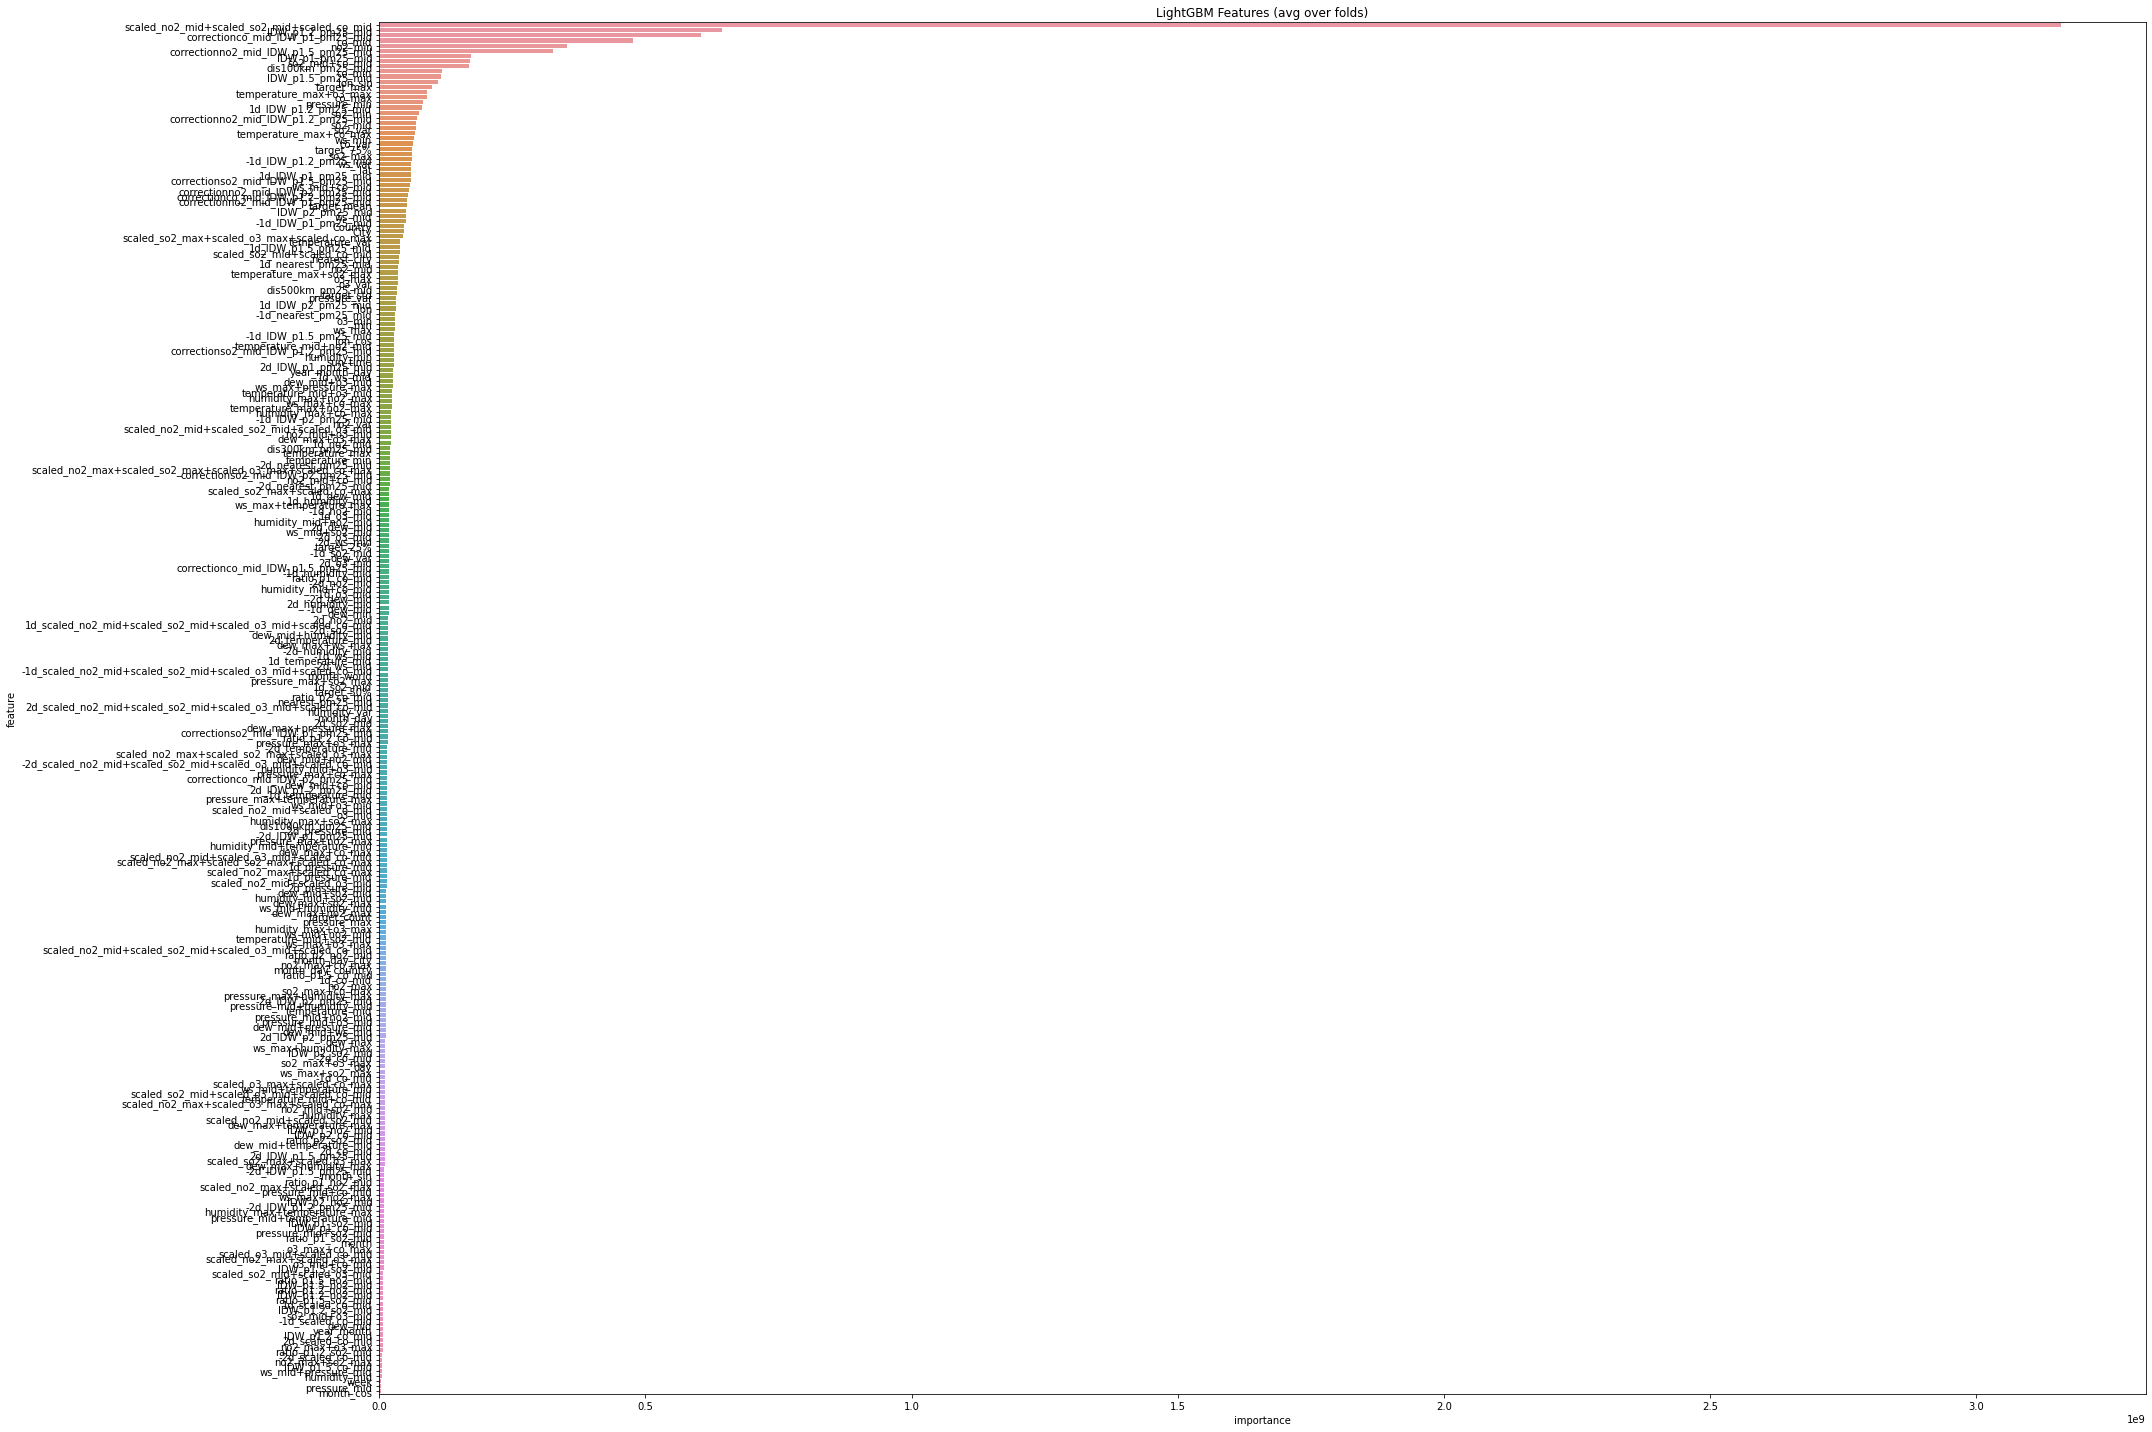

In [ ]:
viz_feature_importances(feature_importance)

In [ ]:
feature_importance.groupby("feature").agg({
    "importance": ["mean", "std"]
}).sort_values(("importance", "mean"), ascending=0).head(50)

importance    
                                                     mean std
feature                                                      
scaled_no2_mid+scaled_so2_mid+scaled_co_mid  3.160000e+09 NaN
IDW_p1.2_pm25_mid                            6.436418e+08 NaN
correctionco_mid_IDW_p1_pm25_mid             6.037298e+08 NaN
co_mid                                       4.760972e+08 NaN
no2_min                                      3.526915e+08 NaN
correctionno2_mid_IDW_p1.5_pm25_mid          3.257035e+08 NaN
IDW_p1_pm25_mid                              1.723961e+08 NaN
so2_mid+co_mid                               1.695530e+08 NaN
dis100km_pm25_mid                            1.677803e+08 NaN
co_min                                       1.184375e+08 NaN
IDW_p1.5_pm25_mid                            1.152030e+08 NaN
lon_sin                                      1.108289e+08 NaN
target_max                                   9.882643e+07 NaN
temperature_max+o3_max                       9.022717e+07 NaN
co_max                                       8.864605e+07 NaN
pressure_min                                 8.297249e+07 NaN
1d_IDW_p1.2_pm25_mid                         7.928320e+07 NaN
so2_min                                      7.420953e+07 NaN
correctionno2_mid_IDW_p1.2_pm25_mid          7.043015e+07 NaN
so2_mid                                      6.967146e+07 NaN
so2_var                                      6.830804e+07 NaN
temperature_max+co_max                       6.730247e+07 NaN
ws_min                                       6.473960e+07 NaN
co_var                                       6.335271e+07 NaN
target_75%                                   6.216202e+07 NaN
so2_max                                      6.174682e+07 NaN
-1d_IDW_p1.2_pm25_mid                        6.133727e+07 NaN
ws_var                                       5.977682e+07 NaN
lat                                          5.934890e+07 NaN
1d_IDW_p1_pm25_mid                           5.918277e+07 NaN
correctionso2_mid_IDW_p1.5_pm25_mid          5.909408e+07 NaN
ws_mid+co_mid                                5.714423e+07 NaN
correctionno2_mid_IDW_p2_pm25_mid            5.530996e+07 NaN
correctionco_mid_IDW_p1.2_pm25_mid           5.425930e+07 NaN
correctionno2_mid_IDW_p1_pm25_mid            5.253337e+07 NaN
target_mean                                  5.165187e+07 NaN
IDW_p2_pm25_mid                              5.058258e+07 NaN
ws_mid                                       5.052946e+07 NaN
-1d_IDW_p1_pm25_mid                          4.917713e+07 NaN
Country                                      4.601634e+07 NaN
City                                         4.561904e+07 NaN
scaled_so2_max+scaled_o3_max+scaled_co_max   4.403373e+07 NaN
temperature_var                              3.973478e+07 NaN
1d_IDW_p1.5_pm25_mid                         3.963389e+07 NaN
scaled_so2_mid+scaled_co_mid                 3.813446e+07 NaN
nearest_city                                 3.674619e+07 NaN
1d_nearest_pm25_mid                          3.662381e+07 NaN
no2_mid                                      3.535853e+07 NaN
temperature_max+so2_max                      3.519808e+07 NaN
o3_max                                       3.497271e+07 NaN

In [ ]:
a = np.clip(train_oof["oof"], 0, 450)
oof_score = np.sqrt(mean_squared_error(train_oof["pm25_mid"], a))
oof_score = format(oof_score, ".4f")
print(f"oof score: {oof_score}")

### d_cs_flg 21.89 ###

oof score: 21.4323


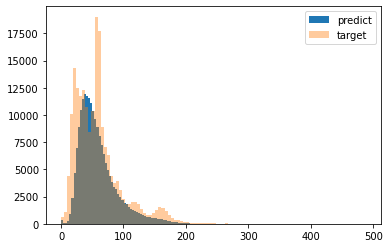

In [ ]:
plt.hist(a, bins = 100, label = "predict")
plt.hist(train_oof["pm25_mid"], bins = 100, label = "target", alpha = 0.4)
plt.legend()
plt.show()

In [ ]:
train_oof[["id","pm25_mid", "kfold", "oof"]].to_csv(os.path.join(OOF_DIR, "oof.csv"), index= False)

In [ ]:
models = []
for i in range(NUM_FOLDS):
    with open(os.path.join(SAVE_DIR, f"model_{i}.pkl"), "rb") as p:
        model = pickle.load(p)
    models.append(model)

# predict

In [ ]:
sum_predict = None
for model in models:
    predict = model.predict(
        test_df__[use_cols],
    )
    if sum_predict is None:
        sum_predict = predict
    else:
        sum_predict += predict

mean_predict = sum_predict / len(models)

In [ ]:
print(len(mean_predict))
print(sample_df.shape)
print(test_df.shape)

53509
(53509, 2)
(53509, 79)


In [ ]:
sample_df.loc[:,"predict"] = np.clip(mean_predict, 0, 450)

In [ ]:
sample_df.head()

,id,predict
0,195942,28.925507
1,195943,42.676172
2,195944,33.678912
3,195945,72.466335
4,195946,127.004480


In [ ]:
sample_df.to_csv(os.path.join(SUB_DIR, "submission.csv"), index= False, header = False)

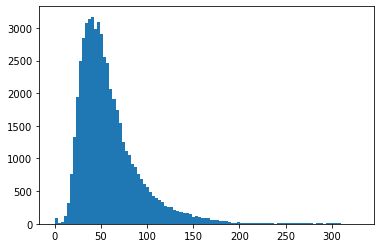

In [ ]:
plt.hist(sample_df["predict"], bins = 100)
plt.show()

# submit

In [ ]:
!pip install signate > /dev/null
!mkdir /root/.signate
!cp /content/drive/MyDrive/signate/signate.json /root/.signate/signate.json

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
submission_file = os.path.join(SUB_DIR, "submission.csv")

In [ ]:
comment = f"cv:{oof_score}_" + NOTEBOOK_NAME
comment

'cv:21.4323_FP058-57'

# Submit

In [ ]:
!signate submit --competition-id=624 {submission_file} --note {comment}

You have successfully submitted your predictions.We will send you the submission result to your email address.


https://signate.jp/competitions/624/submissions

In [ ]:
train_df[["City", "month", "pm25_mid"]].groupby(["City"]).describe()

month                                                pm25_mid  \
              count      mean       std  min  25%  50%   75%   max    count   
City                                                                          
Adapazarı     962.0  6.536383  3.356269  1.0  4.0  6.0   9.0  12.0    962.0   
Akita         978.0  6.527607  3.436774  1.0  4.0  6.0  10.0  12.0    978.0   
Albuquerque   917.0  6.679389  3.347707  1.0  4.0  7.0  10.0  12.0    917.0   
Andong       1011.0  6.608309  3.431492  1.0  4.0  7.0  10.0  12.0   1011.0   
Antakya       734.0  6.779292  3.200069  1.0  4.0  7.0  10.0  12.0    734.0   
...             ...       ...       ...  ...  ...  ...   ...   ...      ...   
Zhuzhou      1059.0  6.610954  3.425374  1.0  4.0  7.0  10.0  12.0   1059.0   
Ürümqi       1033.0  6.642788  3.399611  1.0  4.0  7.0  10.0  12.0   1033.0   
İzmit        1013.0  6.553801  3.346923  1.0  4.0  7.0   9.0  12.0   1013.0   
Łódź          753.0  6.701195  3.238681  1.0  4.0  7.0   9.0  12.0    753.0   
Ōita         1057.0  6.621570  3.406298  1.0  4.0  7.0  10.0  12.0   1057.0   

                                                                         \
                  mean        std     min       25%      50%        75%   
City                                                                      
Adapazarı    63.232831  35.395245   6.460  39.56125  55.6930   73.47475   
Akita        45.871133  25.458542   6.364  28.59525  40.5160   57.69725   
Albuquerque  42.865439  28.188976   7.736  22.31000  34.6630   57.03700   
Andong       59.396874  31.321281   6.600  37.84050  56.9850   69.45200   
Antakya      58.372569  41.630375   2.125  27.77575  53.3615   68.76650   
...                ...        ...     ...       ...      ...        ...   
Zhuzhou      88.612365  43.927142  13.978  57.70200  75.5570  117.65500   
Ürümqi       81.598576  57.824517   9.867  47.92700  61.1770   92.37700   
İzmit        57.312069  29.037306   8.437  36.52600  54.2140   68.27100   
Łódź         61.209457  30.803510  11.894  40.49800  56.6420   73.41000   
Ōita         43.637044  20.845038   6.685  26.33400  40.2000   57.08000   

                      
                 max  
City                  
Adapazarı    181.469  
Akita        218.085  
Albuquerque  173.738  
Andong       191.630  
Antakya      286.452  
...              ...  
Zhuzhou      236.485  
Ürümqi       406.464  
İzmit        176.600  
Łódź         216.704  
Ōita         135.558  

[239 rows x 16 columns]

In [ ]:
test_df__[["IDW_p1_pm25_mid", "IDW_p2_pm25_mid"]]

,IDW_p1_pm25_mid,IDW_p2_pm25_mid
0,90.797173,76.148287
1,109.860292,124.893974
2,76.935167,65.691167
3,102.925348,121.052838
4,80.203378,68.010018
...,...,...
53504,72.703882,95.819913
53505,60.934877,57.623437
53506,73.706546,98.219577
53507,63.027719,77.876075


In [ ]:
train_df[["co_cnt", "co_var", "co_min", "co_max", "co_mid"]]

,co_cnt,co_var,co_min,co_max,co_mid
0,38,0.850,0.749,2.633,2.590
1,47,1.208,2.594,4.828,3.181
2,17,0.248,1.190,2.200,1.197
3,63,24.186,4.586,14.802,11.044
4,47,10.011,4.689,11.100,8.681
...,...,...,...,...,...
195936,12,0.090,0.694,1.301,0.995
195937,14,1.743,0.528,3.226,1.256
195938,171,5.293,1.975,6.639,6.627
195939,31,4.317,2.613,8.767,2.704


In [ ]:
gen = np.random.default_rng()

rnd = gen.normal(size=38)

print(len(rnd), rnd.mean(), rnd.std())

38 -0.06524727250813381 0.9565225513315604


(array([ 1.,  0.,  0.,  2.,  5.,  5., 10.,  9., 13., 17., 19., 22., 14.,
        17., 22., 20., 25., 25., 16., 27., 19., 20., 23., 21., 27., 27.,
        32., 38., 47., 41., 31., 34., 13., 22., 18.,  3., 13., 20., 11.,
        15., 11.,  8.,  7.,  7.,  6.,  3.,  3.,  9.,  6.,  6.,  9.,  4.,
         2.,  6.,  2.,  4.,  2.,  2.,  4.,  1.,  5.,  2.,  6.,  4.,  9.,
         7.,  2.,  4.,  2.,  3.,  1.,  1.,  2.,  4.,  2.,  2.,  2.,  2.,
         4.,  0.,  3.,  2.,  2.,  3.,  4.,  3.,  2.,  7.,  5.,  5.,  1.,
         3.,  3.,  0.,  2.,  1.,  2.,  2.,  0.,  2.]),
 array([  6.46   ,   8.21009,   9.96018,  11.71027,  13.46036,  15.21045,
         16.96054,  18.71063,  20.46072,  22.21081,  23.9609 ,  25.71099,
         27.46108,  29.21117,  30.96126,  32.71135,  34.46144,  36.21153,
         37.96162,  39.71171,  41.4618 ,  43.21189,  44.96198,  46.71207,
         48.46216,  50.21225,  51.96234,  53.71243,  55.46252,  57.21261,
         58.9627 ,  60.71279,  62.46288,  64.21297,  65.96306,  

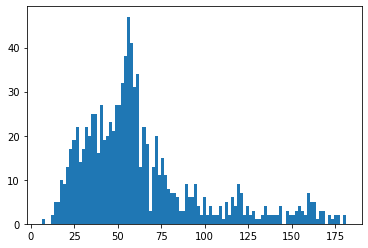

In [ ]:
plt.hist(train_df[train_df["City"] == "Adapazarı"]["pm25_mid"], bins = 100)